In [2]:
from geographical_spatial_strength_extensions import *
from os import listdir
import imp
import sys
import math
import scipy.io as sio
import matplotlib

In [71]:
imp.reload(sys.modules['geographical_spatial_strength_extensions'])

<module 'geographical_spatial_strength_extensions' from 'C:\\Users\\Andy\\Desktop\\Work\\github\\networks\\fitness\\geographical_spatial_strength_extensions.py'>

In [3]:
#full-width figure
# font = {'size'   : 20,
#         'family':'serif',
#         'sans-serif':['Helvetica']}

#half-width figure
font = {'size' : 35,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
marker_cycle = ['o', 's', '*', '+', 'd', '<', 'p']

In [61]:
g = SimpleSpatialGraph()

In [70]:
g.nodes[0]

{'coordinate': [0.20315318085913325, 0.9161185119237587]}

In [62]:
for i in g.nodes:
    print(i)

In [6]:
generate_rgg(50, 0.2)

In [5]:
def generate_rgg(n, r, size=1, pbc=False):
    '''
    generate a random geometric graph where and edge exists between nodes
    if they are within a distance of r from each other
    '''
    G = SimpleSpatialGraph(size=[size, size])
    for _ in range(n):
        G.add_node()
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j)
                G[i][j]['distance'] = distances[i][j]
                
    return G

def generate_lattice(rows=5, columns=5, size=1):
    '''
    generate a lattice graph defined by number of rows and columns where
    number of nodes = rows * columns, and nodes that are north, south,
    east, west of each other will be adjacent
    '''
    G = SimpleSpatialGraph(size=[size, size])
    row_step = size / rows
    column_step = size / columns
    
    #create nodes
    for i in range(rows):
        for j in range(columns):
            G.add_node(coordinate=[j * column_step + 0.5 * column_step, i * row_step + 0.5 * row_step])
    
    #create edges
    #for each node, add edges to the right and above
    distances = []
    for i in range(rows):
        for j in range(columns):
            node_num = i * columns + j
            #edge above
            if(i < rows - 1):
                G.add_edge(node_num, node_num + columns)
            #edge to the right
            if(j < columns - 1):
                G.add_edge(node_num, node_num + 1)
    return G
    
def generate_web(branches=3, layers=5, radius=1):
    '''
    generate a web network (layered star network)
    branches: branches per layer
    layers: number of layers
    radius: radius per layer
    '''
    G = SimpleSpatialGraph(size=[2 * radius * layers, 2 * radius * layers])
    center = [radius * layers, radius * layers]
    G.add_node(coordinate=center)
    backstep = math.floor(branches / 2)
    
    append_to_node = 0
    branch_count = 0
    current_node = 0
    add_to_label = 1
        
    for n in range(1, layers):
        theta_step = 2 * math.pi / (branches ** n) 
        for i in range(-backstep, branches ** n - backstep):
            branch_count += 1
            current_node += 1
            
            theta = theta_step * i
            x = math.cos(theta) * n * radius + center[0]
            y = math.sin(theta) * n * radius + center[1]
            label = add_to_label + (i % branches ** n)
            G.add_node(label=label, coordinate=[x, y])
            G.add_edge(append_to_node, label)
            
            if(branch_count == branches):
                branch_count = 0
                append_to_node += 1
                
        add_to_label += branches ** n
    
    return G

def load_fungal_network(filename):
    data = sio.loadmat(open('datasets/Conductance/' + filename, 'rb'))
    xmin = np.min(data['coordinates'].T[0])
    xmax = np.max(data['coordinates'].T[0])
    ymin = np.min(data['coordinates'].T[1])
    ymax = np.max(data['coordinates'].T[1])
    g = SimpleSpatialGraph(size=[xmax-xmin, ymax-ymin])
    for coord in data['coordinates']:
        coord = [coord[0] - xmin, coord[1] - ymin]
        g.add_node(coordinate=coord)
    for node in range(g.node_count):
        for node2, strength in enumerate(data['A'][node].toarray()[0]):
            if(strength > 0):
                g.add_edge(node, node2)
    return g

def get_fungal_network_by_index(index):
    g = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[88], 'rb'))
    return g

def load_city_network(continent, city):
    node_data = open('datasets/road_data_2km/' + continent + '/' + city + '_node.txt', 'r')
    edge_data = open('datasets/road_data_2km/' + continent + '/' + city + '_edge.txt', 'r')
    labels = []
    coordsx = []
    coordsy = []
    for line in node_data:
        data = line.split('\n')[0].split(' ')
        labels.append(data[0])
        coordsx.append(float(data[1]))
        coordsy.append(float(data[2]))
    xmin = np.min(coordsx)
    xmax = np.max(coordsx)
    ymin = np.min(coordsy)
    ymax = np.max(coordsy)
    coordsx = np.subtract(coordsx, xmin)
    coordsy = np.subtract(coordsy, ymin)
    g = SimpleSpatialGraph(size=[xmax-xmin, ymax-ymin])
    for i in range(len(labels)):
        g.add_node(coordinate=[coordsx[i], coordsy[i]])

    for line in edge_data:
        data = line.split('\n')[0].split(' ')
        g.add_edge(labels.index(data[0]), labels.index(data[1]))
    
    return g

def get_city_by_index(index):
    spatial_strengths = pickle.load(open('datasets/results/roads.pickle', 'rb'))
    regions = ['Africa', 'Asia', 'Europe', 'LatinAmerica', 'US']
    idx = index
    final_region = ''
    final_city = ''
    for region in regions:
        if(idx - len(spatial_strengths[region]) < 0):
            final_city = listdir('datasets/road_networks/' + region + '_2km')[idx]
            final_region = region
            idx = 9999
        else:
            idx = idx - len(spatial_strengths[region])
    print(final_region)
    print(final_city)
    g = pickle.load(open('datasets/road_networks/' + final_region + '_2km/' + final_city, 'rb'))
    return g

In [40]:
#generate graphs and collect results
nodes = [400, 500, 600, 700, 800, 900, 1000]
radii = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
trials = 50
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []

for n in nodes:
    for r in radii:
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets))
        results = {
            'graphs': [],
            'centralities': [],
            'spatial_strength': []
        }
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False)
            results['spatial_strength'].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['spatial_strength']))
        
        pickle.dump(results, open('datasets/results/rgg/ssn_' + str(n) + '_r_' + str(r) + '.pickle', 'wb'))
        

set: 1 out of 140
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0458712774285
Average Spatial Strength: 0.0358099564225
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0423262848613
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0595617536779
Average Spatial Strength: 0.0
Average Spatial Strength: 0.519856516686
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0651036899053
Average Spatial Strength: 0.0448338521152
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0

KeyboardInterrupt: 

In [177]:
#generate graphs and collect results
#don't save the graphs only collect final spatial strengths

nodes = [10, 50, 100, 300, 500, 700, 900, 1000]
radii = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
trials = 20
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []
results = {}

for n in nodes:
    for r in radii:
        results['n_' + str(n) + '_r_' + str(r)] = []
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets) + '. n: ' + str(n) + ', r: ' + str(r))
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
            results['n_' + str(n) + '_r_' + str(r)].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        print(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        
results['graph_n'] = graph_n
results['graph_r'] = graph_r
results['avg_spatial_strengths'] = avg_spatial_strength

set: 1 out of 96. n: 10, r: 0.01
0.0
set: 2 out of 96. n: 10, r: 0.02
0.0
set: 3 out of 96. n: 10, r: 0.03
0.004
set: 4 out of 96. n: 10, r: 0.05
0.0200712379304
set: 5 out of 96. n: 10, r: 0.07
0.0307467844195
set: 6 out of 96. n: 10, r: 0.1
0.0877892894072
set: 7 out of 96. n: 10, r: 0.15
0.247312678778
set: 8 out of 96. n: 10, r: 0.2
0.409578340457
set: 9 out of 96. n: 10, r: 0.25
0.871692913356
set: 10 out of 96. n: 10, r: 0.3
0.910444505732
set: 11 out of 96. n: 10, r: 0.4
1.08459290471
set: 12 out of 96. n: 10, r: 0.5
0.947435867461
set: 13 out of 96. n: 50, r: 0.01
0.00132945713139
set: 14 out of 96. n: 50, r: 0.02
0.00447483562516
set: 15 out of 96. n: 50, r: 0.03
0.0232131824078
set: 16 out of 96. n: 50, r: 0.05
0.146964751954
set: 17 out of 96. n: 50, r: 0.07
0.420906222109
set: 18 out of 96. n: 50, r: 0.1
0.759344370164
set: 19 out of 96. n: 50, r: 0.15
1.09700896
set: 20 out of 96. n: 50, r: 0.2
1.24775055362
set: 21 out of 96. n: 50, r: 0.25
1.0386684765
set: 22 out of 96.

In [179]:
pickle.dump(results, open('datasets/results/rgg/rgg_n10-1000_r001-05.pickle', 'wb'))

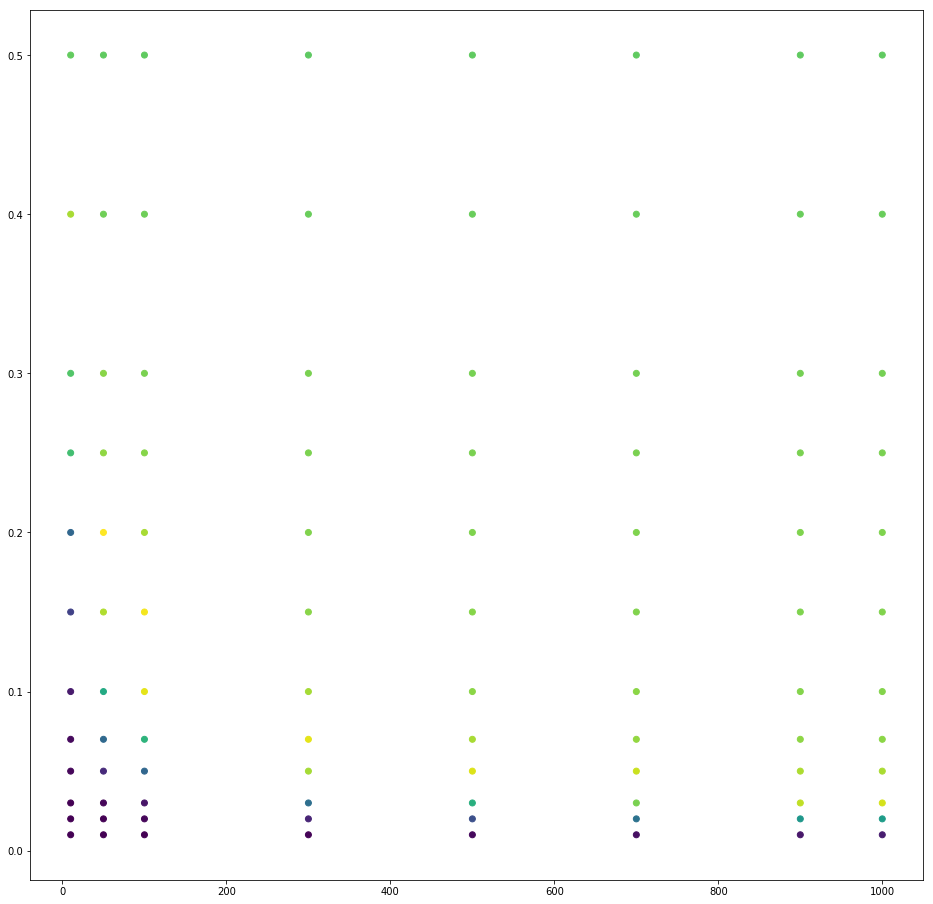

In [180]:
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-05.pickle', 'rb'))
plt.figure(figsize=(16, 16))
plt.scatter(results['graph_n'], results['graph_r'], c=results['avg_spatial_strengths'], cmap='viridis')

In [3]:
#generate more granulated results around interesting area

nodes = [10, 50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
radii = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
trials = 20
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []
results = {}

for n in nodes:
    for r in radii:
        results['n_' + str(n) + '_r_' + str(r)] = []
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets) + '. n: ' + str(n) + ', r: ' + str(r))
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality2(g, pbc=False, ret=True, graph=False, print_result=False, normalized=True)
            results['n_' + str(n) + '_r_' + str(r)].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        print(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        
results['graph_n'] = graph_n
results['graph_r'] = graph_r
results['avg_spatial_strengths'] = avg_spatial_strength

set: 1 out of 200. n: 10, r: 0.01
0.0
set: 2 out of 200. n: 10, r: 0.02
0.184860145797
set: 3 out of 200. n: 10, r: 0.03
0.321109547074
set: 4 out of 200. n: 10, r: 0.04
0.37124387669
set: 5 out of 200. n: 10, r: 0.05
0.234465283177
set: 6 out of 200. n: 10, r: 0.06
0.570997985799
set: 7 out of 200. n: 10, r: 0.07
0.996292578898
set: 8 out of 200. n: 10, r: 0.08
1.44262449316
set: 9 out of 200. n: 10, r: 0.09
1.59528179172
set: 10 out of 200. n: 10, r: 0.1
5.52680357359
set: 11 out of 200. n: 50, r: 0.01
0.315518534635
set: 12 out of 200. n: 50, r: 0.02
1.64748620102
set: 13 out of 200. n: 50, r: 0.03
1.67371613061
set: 14 out of 200. n: 50, r: 0.04
3.62644749898
set: 15 out of 200. n: 50, r: 0.05
6.772073847
set: 16 out of 200. n: 50, r: 0.06
9.69681657629
set: 17 out of 200. n: 50, r: 0.07
13.0844492724
set: 18 out of 200. n: 50, r: 0.08
12.8700836395
set: 19 out of 200. n: 50, r: 0.09
17.2059873445
set: 20 out of 200. n: 50, r: 0.1
20.3632689218
set: 21 out of 200. n: 100, r: 0.01
0

In [93]:
np.random.randint(-25, 25)

12

In [97]:
#generate more granulated results around interesting area
all_scatter['rgg'] = {
    'ns': [],
    'strengths': []
}
nodes = [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
radii = 0.07
trials = 20
count = 0

for n in nodes:
    
    count += 1
    for i in range(trials):
        g = generate_rgg(n + np.random.randint(-25, 25), radii, pbc=False)
        centrality, spatial_strength = report_spatial_strength_centrality2(g, pbc=False, ret=True, graph=False, print_result=False, normalized=True)
        all_scatter['rgg']['ns'].append(len(g.nodes))
        all_scatter['rgg']['strengths'].append(spatial_strength)
        

In [4]:
pickle.dump(results, open('datasets/results/rgg/rgg_n10-1000_r001-01_2_2.pickle', 'wb'))

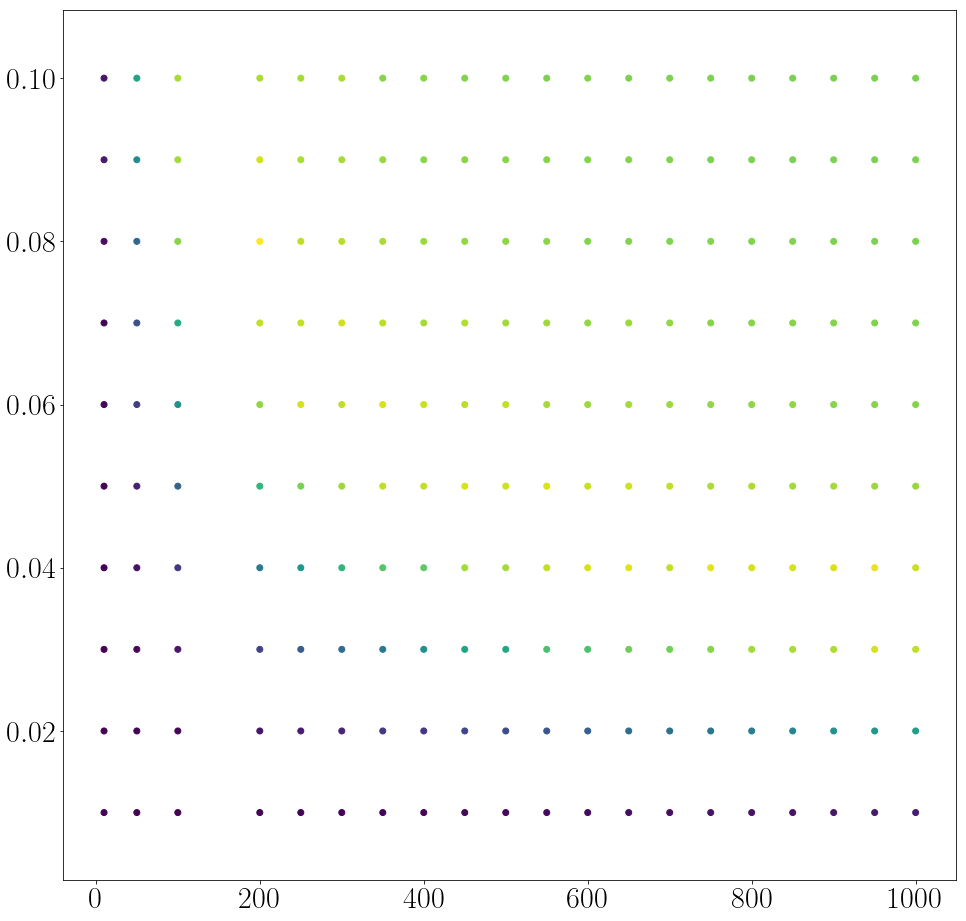

In [25]:
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-01_2.pickle', 'rb'))
plt.figure(figsize=(16, 16))
plt.scatter(results['graph_n'], results['graph_r'], c=results['avg_spatial_strengths'], cmap='viridis')

In [23]:
pickle.dump(rgg, open('spatial_rgg_example', 'wb'))

Average Spatial Strength: 1.44583315207


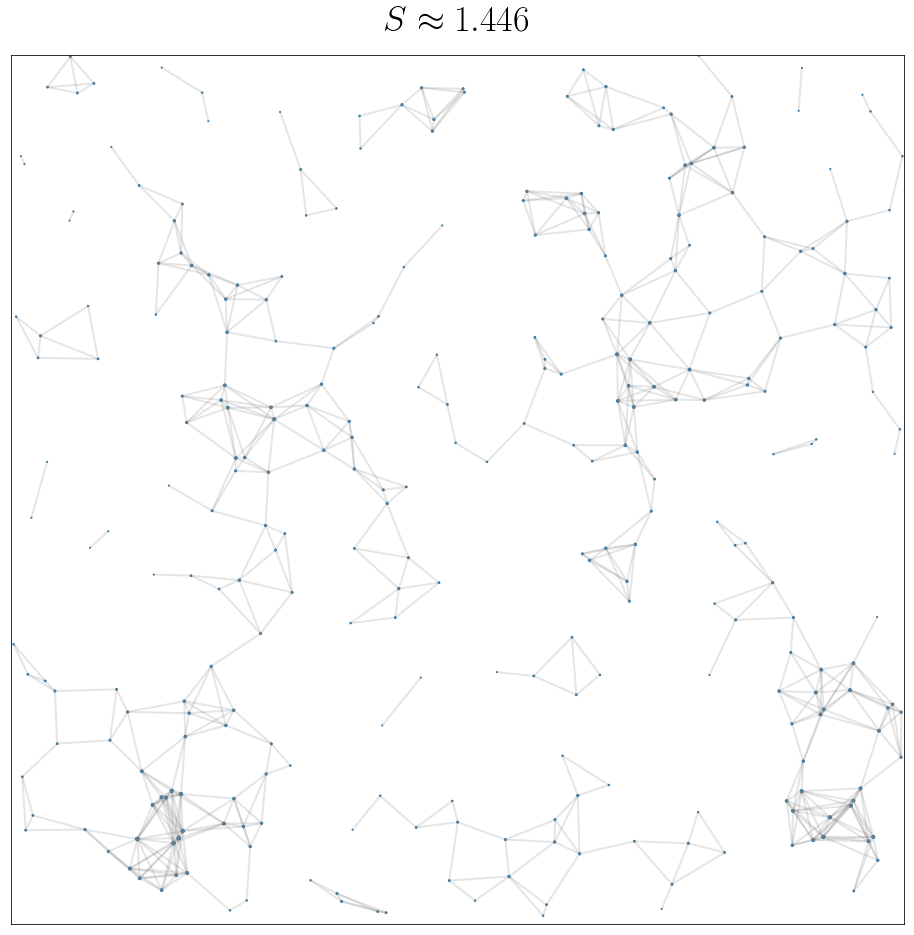

In [7]:
rgg = generate_rgg(300, 0.07)
graph_spatial_network_plot_valued(rgg, graph_edges=True, pbc=False, ss_title=True)

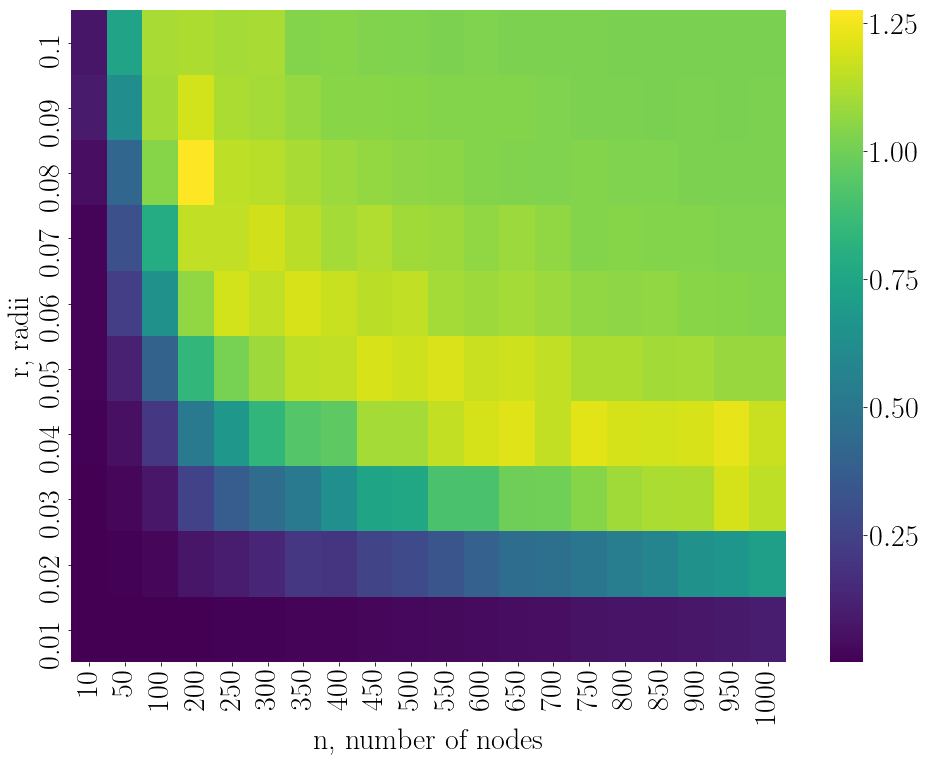

In [33]:

heat = pd.DataFrame(columns=['graph_n', 'graph_r', 'avg_spatial_strengths'])
heat['graph_n'] = results['graph_n']
heat['graph_r'] = results['graph_r']
heat['avg_spatial_strengths'] = results['avg_spatial_strengths']
heatmap = heat.pivot('graph_r', 'graph_n', 'avg_spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')

ax.set_xlabel('n, number of nodes')
ax.set_ylabel('r, radii')
plt.savefig('figures/rgg_spatial_strength.pdf', bbox_inches='tight')

In [29]:
rows = [5, 10, 15, 20, 25, 30]
columns = rows
graph_rows = []
graph_cols = []
spatial_strengths = []
for row in rows:
    for col in columns:
        print('row: ', row, ', col: ', col)
        g = generate_lattice(row, col, size=10)
        spatial_strength = spatial_strength_centrality(g, pbc=False)[1]
        spatial_strengths.append(spatial_strength)
        graph_rows.append(row)
        graph_cols.append(col)


row:  5 , col:  5
row:  5 , col:  10
row:  5 , col:  15
row:  5 , col:  20
row:  5 , col:  25
row:  5 , col:  30
row:  10 , col:  5
row:  10 , col:  10
row:  10 , col:  15
row:  10 , col:  20
row:  10 , col:  25
row:  10 , col:  30
row:  15 , col:  5
row:  15 , col:  10
row:  15 , col:  15
row:  15 , col:  20
row:  15 , col:  25
row:  15 , col:  30
row:  20 , col:  5
row:  20 , col:  10
row:  20 , col:  15
row:  20 , col:  20
row:  20 , col:  25
row:  20 , col:  30
row:  25 , col:  5
row:  25 , col:  10
row:  25 , col:  15
row:  25 , col:  20
row:  25 , col:  25
row:  25 , col:  30
row:  30 , col:  5
row:  30 , col:  10
row:  30 , col:  15
row:  30 , col:  20
row:  30 , col:  25
row:  30 , col:  30


In [6]:
spatial_strengths

[0.15888888888888883,
 0.20204311111111115,
 0.22488266666666609,
 0.23882175287495347,
 0.24818360504104725,
 0.25489578112644345,
 0.20204311111111106,
 0.28222222222222226,
 0.3324131546699316,
 0.36632378328741955,
 0.39070556865714418,
 0.40906225895316201,
 0.22488266666666645,
 0.33241315466993188,
 0.40666666666666224,
 0.46027869999466292,
 0.50070740051694529,
 0.53225640138408359,
 0.23882175287495347,
 0.36632378328741871,
 0.46027869999466231,
 0.5313888888888888,
 0.58695156167158413,
 0.63152804250788341,
 0.24818360504104719,
 0.39070556865714345,
 0.50070740051694462,
 0.58695156167158458,
 0.65622222222227711,
 0.7130380537978549,
 0.2548957811264444,
 0.40906225895316267,
 0.5322564013840847,
 0.63152804250788341,
 0.71303805379785234,
 0.78111111111109954]

In [4]:
def spatial_strength_centrality2(G, pbc=True, normalized=True):
    '''
    calculate spatial strength centrality by dividing each edge distance
    by its corresponding degree so that we correctly weight the edges
    '''
    distances = pbc_distances(G, pbc=pbc)
    distances = distances + distances.T
    centralities = {}
    avg_k = average_degree(G)

    total_edge_length = 0
    num_edges = 0
    total_spatial_strength = 0

    for i in range(G.node_count):
        sum_distances = 0
        for e in G[i]:
            sum_distances += distances[i][e] / G.degree(e)
            total_edge_length += distances[i][e]
            num_edges += 1
        avg_distance = 0
        if(G.degree[i] != 0):
            avg_distance = sum_distances / G.degree[i]

        centralities[i] = avg_distance

    if(normalized):
        if(num_edges == 0):
            avg_edge_length = 0
        else:
            avg_edge_length = total_edge_length / num_edges

        for i in range(G.node_count):
            if(avg_edge_length == 0):
                centralities[i] = 0
            else:
                centralities[i] = centralities[i] / avg_edge_length
                total_spatial_strength += centralities[i]

    average_spatial_strength = total_spatial_strength / G.node_count

    return centralities, average_spatial_strength

In [20]:
for i in range(g.node_count):
    print(i)
    for e in g[i]:
        print(distances[i][e] / g.degree(e))

0
0.111111111111
0.111111111111
1
0.166666666667
0.0833333333333
0.111111111111
2
0.111111111111
0.0833333333333
0.111111111111
3
0.111111111111
0.0833333333333
0.111111111111
4
0.111111111111
0.0833333333333
0.111111111111
5
0.111111111111
0.0833333333333
0.111111111111
6
0.111111111111
0.0833333333333
0.111111111111
7
0.111111111111
0.0833333333333
0.111111111111
8
0.111111111111
0.0833333333333
0.111111111111
9
0.111111111111
0.0833333333333
0.111111111111
10
0.111111111111
0.0833333333333
0.111111111111
11
0.111111111111
0.0833333333333
0.111111111111
12
0.111111111111
0.0833333333333
0.111111111111
13
0.111111111111
0.0833333333333
0.111111111111
14
0.111111111111
0.0833333333333
0.111111111111
15
0.111111111111
0.0833333333333
0.111111111111
16
0.111111111111
0.0833333333333
0.111111111111
17
0.111111111111
0.0833333333333
0.111111111111
18
0.111111111111
0.0833333333333
0.111111111111
19
0.111111111111
0.0833333333333
0.111111111111
20
0.111111111111
0.0833333333333
0.1111111111

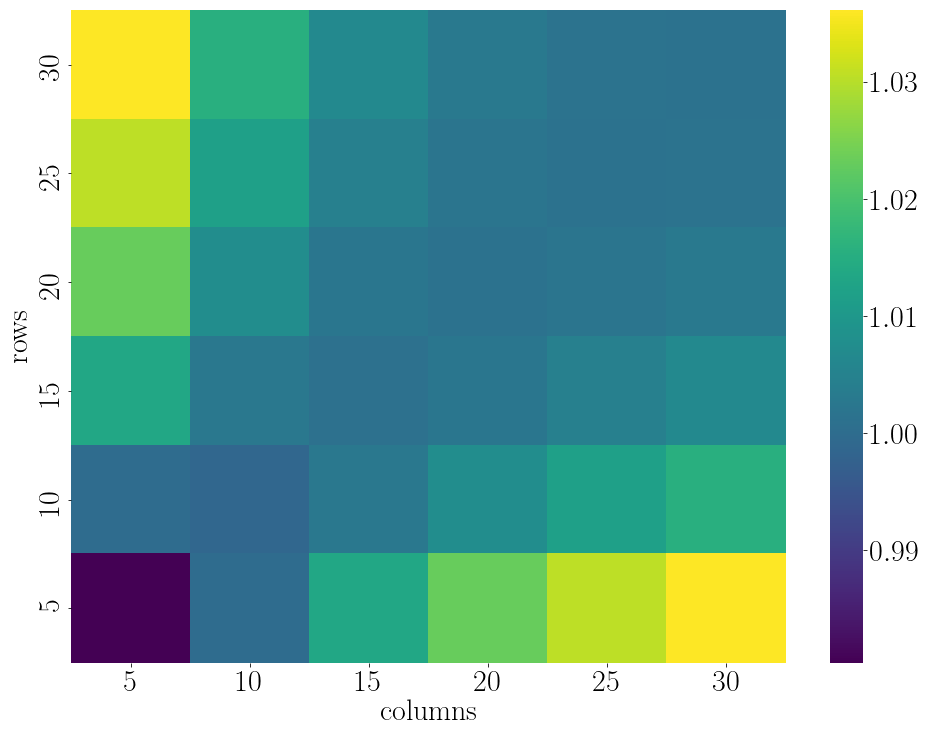

In [30]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['rows'] = graph_rows
heat['cols'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('rows', 'cols', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
#sns.heatmap(heatmap, cmap='viridis', vmin=0.9, vmax=1.1)
sns.heatmap(heatmap, cmap='viridis')

ax.set_xlabel('columns')
ax.set_ylabel('rows')
plt.savefig('figures/lattice_spatial_strength1.pdf', bbox_inches='tight')

Average Spatial Strength: 0.998742857143
Average Spatial Strength: 0.998742857143


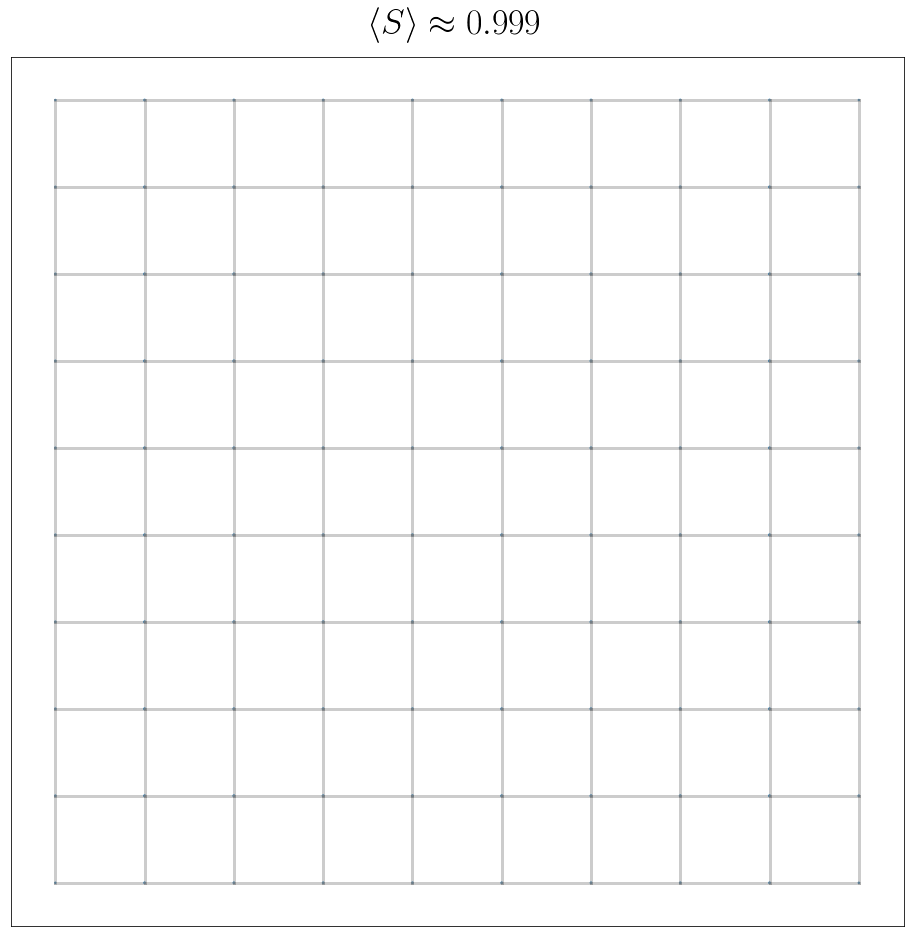

In [4]:
lattice = generate_lattice(rows=10, columns=10)
centralities, _ = report_spatial_strength_centrality(lattice, pbc=False, graph=False, ret=True, normalized=4)
graph_spatial_network_plot_valued(lattice, False, True, ss_title=True, linewidth=3, alpha=0.4)

In [29]:
branches = [1, 2, 3, 4, 5, 6, 7]
layers = [2, 3, 4, 5]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        print('branch: ', branch, ', layer: ', layer)
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)


branch:  1 , layer:  2
branch:  2 , layer:  2
branch:  3 , layer:  2
branch:  4 , layer:  2
branch:  5 , layer:  2
branch:  6 , layer:  2
branch:  7 , layer:  2
branch:  1 , layer:  3
branch:  2 , layer:  3
branch:  3 , layer:  3
branch:  4 , layer:  3
branch:  5 , layer:  3
branch:  6 , layer:  3
branch:  7 , layer:  3
branch:  1 , layer:  4
branch:  2 , layer:  4
branch:  3 , layer:  4
branch:  4 , layer:  4
branch:  5 , layer:  4
branch:  6 , layer:  4
branch:  7 , layer:  4
branch:  1 , layer:  5
branch:  2 , layer:  5
branch:  3 , layer:  5
branch:  4 , layer:  5
branch:  5 , layer:  5
branch:  6 , layer:  5
branch:  7 , layer:  5


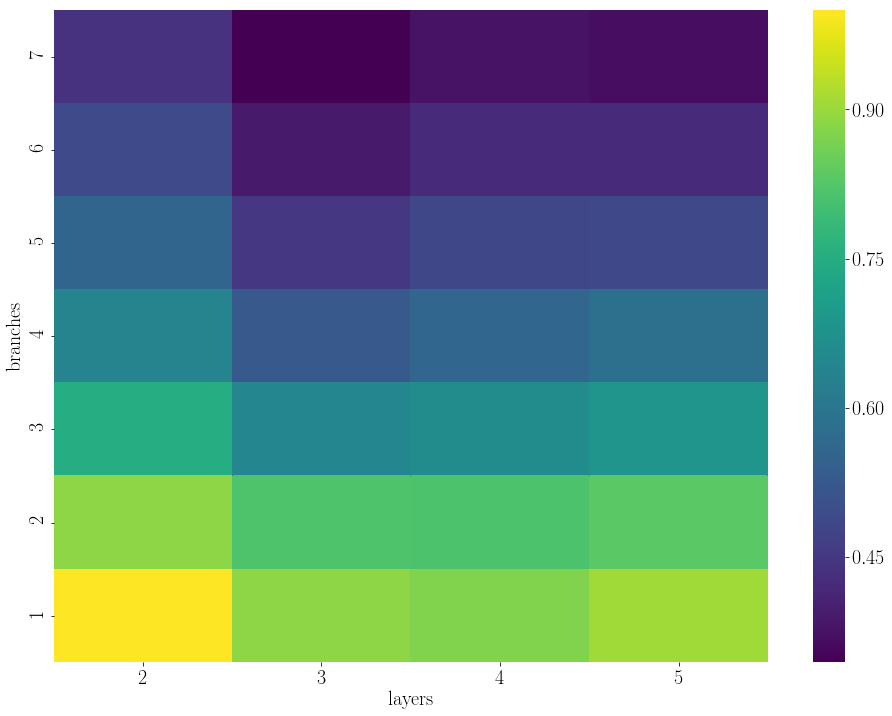

In [30]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['branches'] = graph_rows
heat['layers'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('branches', 'layers', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')
ax.set_xlabel('layers')
ax.set_ylabel('branches')


In [47]:
branches = [3]
layers = [2, 3, 4, 5, 6, 7, 8, 9]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        print('branch: ', branch, ', layer: ', layer)
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)


branch:  3 , layer:  2
branch:  3 , layer:  3
branch:  3 , layer:  4
branch:  3 , layer:  5
branch:  3 , layer:  6
branch:  3 , layer:  7
branch:  3 , layer:  8
branch:  3 , layer:  9


MemoryError: 

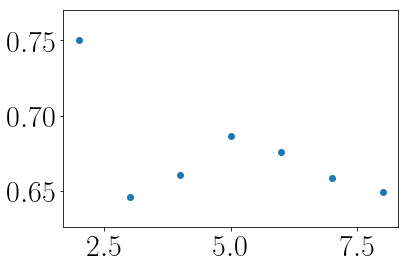

In [46]:
plt.scatter(graph_cols, spatial_strengths)

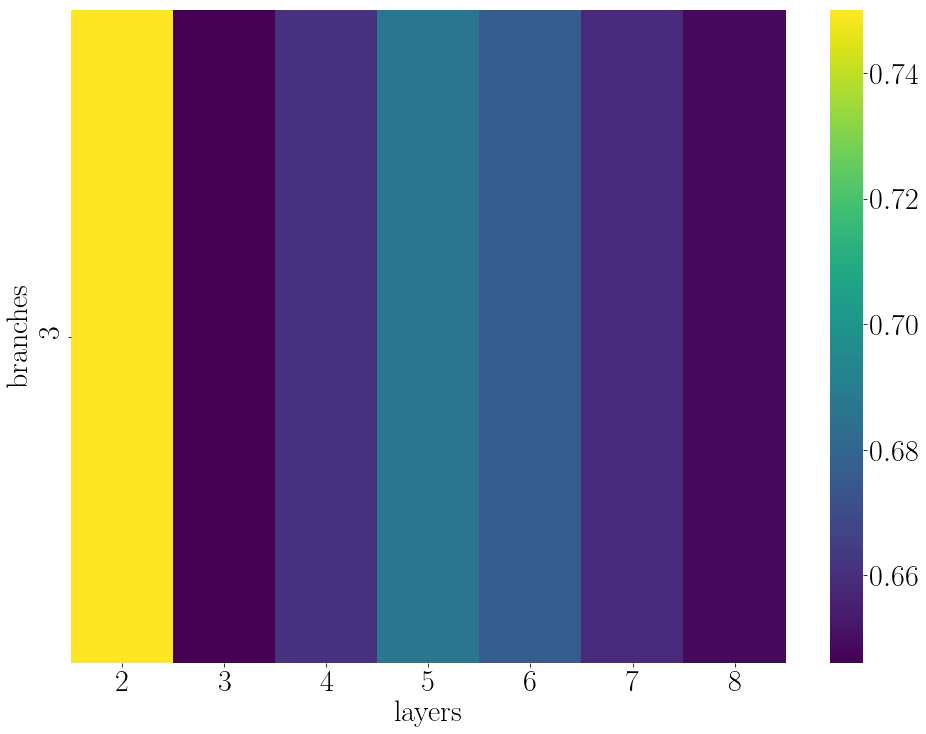

In [43]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['branches'] = graph_rows
heat['layers'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('branches', 'layers', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')
ax.set_xlabel('layers')
ax.set_ylabel('branches')


Average Spatial Strength: 0.686694116237
Average Spatial Strength: 0.686694116237


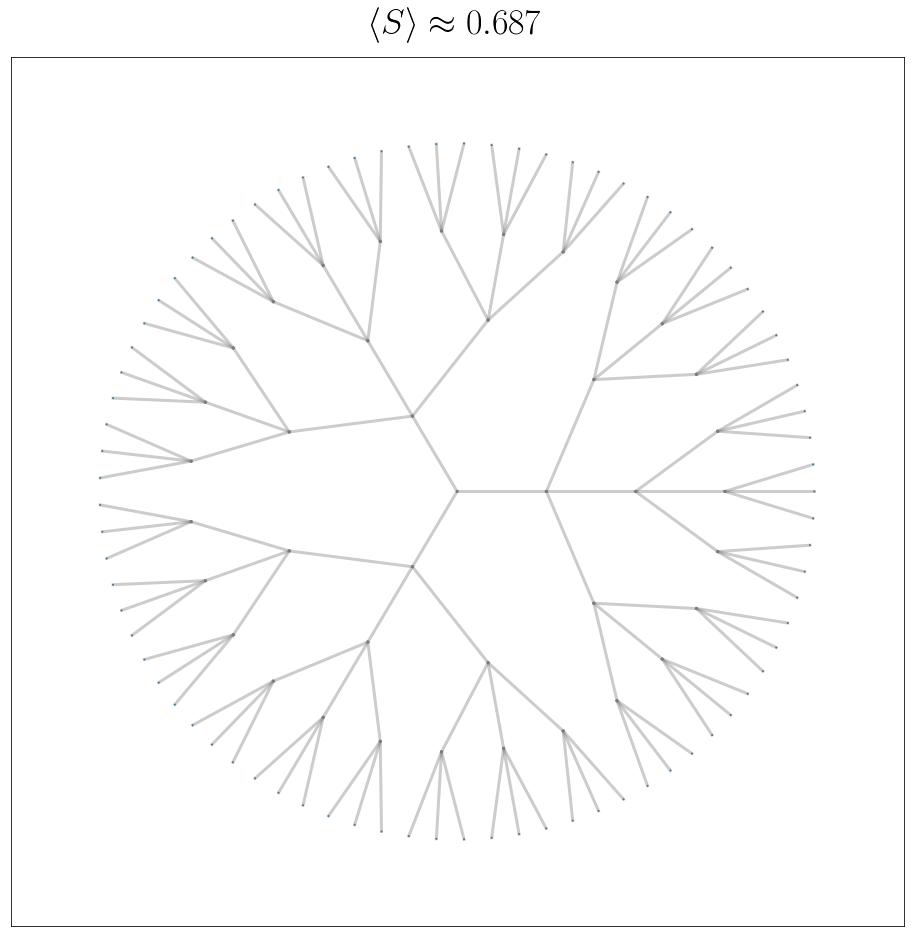

In [5]:
web = generate_web()
centralities, _ =report_spatial_strength_centrality(web, pbc=False, graph=False, ret=True, normalized=4)
graph_spatial_network_plot_valued(web, graph_edges=True, pbc=False, ss_title=True, linewidth=3, alpha=0.4)

In [5]:
#Load all spatial strengths
# spatial_strength_data = {
#     'geographical': pickle.load(open('datasets/results/spatial models/geographical_threshold_spatial_strengths.pickle', 'rb')),
#     'preferential': pickle.load(open('datasets/results/spatial models/preferential_attachment_spatial_strengths.pickle', 'rb')),
#     'configuration': pickle.load(open('datasets/results/spatial models/spatial_configuration_spatial_strengths.pickle', 'rb')),
# }

preferential =  pickle.load(open('datasets/results/spatial models/PA_all_spatial_strengths', 'rb'))[1000]

spatial_strength_data = {
    'geographical': pickle.load(open('datasets/results/spatial models/geographical_threshold_spatial_strengths.pickle', 'rb')),
    'preferential': {},
    'configuration': pickle.load(open('datasets/results/spatial models/n1000_spatconf_spat', 'rb')),
}

for beta in [0,1,2,3,4]:
    spatial_strength_data['preferential'][-beta] = preferential[beta]

r = pd.DataFrame(columns=['type', 'n', 'beta', 'spatial_strength'])

spatial_strength_results = {
}

In [6]:
spatial_strength_data

{'configuration': {'-0.5': [0.65155281021006883,
   0.62839167108443172,
   0.66635237222456045,
   0.66484434060568587,
   0.61854507987209251,
   0.64919376775500537,
   0.65577856554819003,
   0.62957538786162726,
   0.63452031671052711,
   0.61636859763057361,
   0.64441922569584786,
   0.63327985008530419,
   0.63045224811002054,
   0.63749882373329658,
   0.65792328782805931,
   0.65052592709633528,
   0.65423579926515274,
   0.648771604122519,
   0.66367605978441713,
   0.74075042835445304,
   0.64585561266237901,
   0.63502892222412488,
   0.6254781859177061,
   0.62720802153296029,
   0.61769605853056975,
   0.66658078807914156,
   0.65052303051256544,
   0.6257689916536362,
   0.63912319295977182,
   0.68125781514625405],
  '-1.0': [0.65196558702410135,
   0.66255618318753462,
   0.67581156931546449,
   0.69707484915545637,
   0.69745584142823036,
   0.70349998415124126,
   0.71514747976768556,
   0.69483533510109363,
   0.68906941745490125,
   0.67484024745211235,
   0.71348

In [6]:
#add geographical model data to dataframe
spatial_graph_keys = ['geographical', 'preferential', 'configuration']
for graph_type in spatial_graph_keys:
    ssm_results = spatial_strength_data[graph_type]
    results_x = []
    results_y = []
    results_range = []
    for beta in ssm_results.keys():
        sum_spatial_strengths = 0
        for i in range(len(ssm_results[beta])):
            sum_spatial_strengths += ssm_results[beta][i]
        avg_spatial_strength = sum_spatial_strengths / len(ssm_results[beta])
        results_x.append(beta)
        results_y.append(avg_spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = [graph_type, 500, beta, avg_spatial_strength]
        
    results_range.append(np.min(results_y))
    results_range.append(np.max(results_y))
    
    spatial_strength_results[graph_type] = {
        'x': results_x,
        'y': results_y,
        'rng': results_range
    }

    

In [18]:
#not this one
for graph_type in spatial_graph_keys:
    ssm_results = spatial_strength_data[graph_type]
    results_x = []
    results_y = []
    results_range = []
    for beta in ssm_results.keys():      
        next_row = r.shape[0]
        for i in range(len(ssm_results[beta])):
            r.loc[next_row] = [graph_type, 500, beta, ssm_results[beta]]
        
    results_range.append(np.min(results_y))
    results_range.append(np.max(results_y))
    
    spatial_strength_results[graph_type] = {
        'x': results_x,
        'y': results_y,
        'rng': results_range
    }
    
    

ValueError: setting an array element with a sequence

In [21]:
ssm_results[beta]

[0.19353964578353558,
 0.14787164500632641,
 0.17758593358333633,
 0.17019151721862538,
 0.17806720087721295,
 0.14933488298489223,
 0.15903965620296917,
 0.17127847709194841,
 0.16783799030323923,
 0.15910443259185025,
 0.18158125379199763,
 0.19332252703683256,
 0.22437046174634512,
 0.1733691367202902,
 0.18892247032733017,
 0.15557027716089922,
 0.15079160854868237,
 0.17249809195604562,
 0.19068803590133615,
 0.13231022122736011,
 0.16916428431133196,
 0.11455242120376233,
 0.11275497096598069,
 0.17414924436610948,
 0.18847128685446804,
 0.13258491341684486,
 0.17268004610161664,
 0.14235648721456454,
 0.14344491673029472,
 0.1633361074226039]

In [7]:
#add rgg data to dataframe
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-01_2.pickle', 'rb'))
for i in range(len(results['graph_n'])):
    next_row = r.shape[0]
    r.loc[next_row] = ['rgg', results['graph_n'][i], results['graph_r'][i], results['avg_spatial_strengths'][i]]

In [8]:
#add lattice and web data to dataframe
#lattice
all_scatter['web'] = {
    'ns': [],
    'strengths': []
}
all_scatter['lattice'] = {
    'ns': [],
    'strengths': []
}
rows = [5, 10, 15, 20, 25, 30]
columns = rows
graph_rows = []
graph_cols = []
spatial_strengths = []
for row in rows:
    for col in columns:
        g = generate_lattice(row, col, size=10)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(row)
        graph_cols.append(col)
        
        all_scatter['lattice']['ns'].append(row * col)
        all_scatter['lattice']['strengths'].append(spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = ['lattice', row * col, 0, spatial_strength]
        
#web
branches = [1, 2, 3, 4, 5, 6]
layers = [2, 3, 4, 5]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)
        
        all_scatter['web']['ns'].append(len(g.nodes))
        all_scatter['web']['strengths'].append(spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = ['web', branch ** (layer - 1) + 1, 0, spatial_strength]


NameError: name 'all_scatter' is not defined

In [10]:
#add fungal and road data to dataframe
fungal = pickle.load(open('datasets/results/fungal.pickle', 'rb'))
for i in range(len(fungal)):
    next_row = r.shape[0]
    r.loc[next_row] = ['fungal', 0, 0, fungal[i]]
roads = pickle.load(open('datasets/results/roads.pickle', 'rb'))
for i in range(len(roads['all_results'])):
    next_row = r.shape[0]
    r.loc[next_row] = ['roads', 0, 0, roads['all_results'][i]]

In [63]:
len(roads['all_results'])

101

In [15]:
all_scatter = {
    'fungal': {
        'ns': ns,
        'strengths': fungal
    },
    'roads': {
        'ns': ns2,
        'strengths': roads['all_results']
    }
}

NameError: name 'ns' is not defined

In [112]:
pickle.dump(all_scatter, open('datasets/results/strengths_scatter_1', 'wb'))

In [77]:
all_scatter['web']

{'ns': [], 'strengths': []}

In [9]:
rgg2 = {
    'ns': [],
    'strengths': []
}
for i, n in enumerate(all_scatter['rgg']['ns']):
    if(i % 5 == 0):
        rgg2['ns'].append(n)
        rgg2['strengths'].append(all_scatter['rgg']['strengths'][i])

all_scatter['rgg2'] = rgg2

NameError: name 'all_scatter' is not defined

In [11]:
pa_spat = pickle.load(open('graphs/PA/all_spatial_strengths', 'rb'))

In [111]:
all_scatter['PA'] = {
    'ns': [],
    'strengths': []
}
for n in [300, 1000, 3000, 10000]:
    for i in pa_spat[n][3]:
        all_scatter['PA']['ns'].append(n)
        all_scatter['PA']['strengths'].append(i)

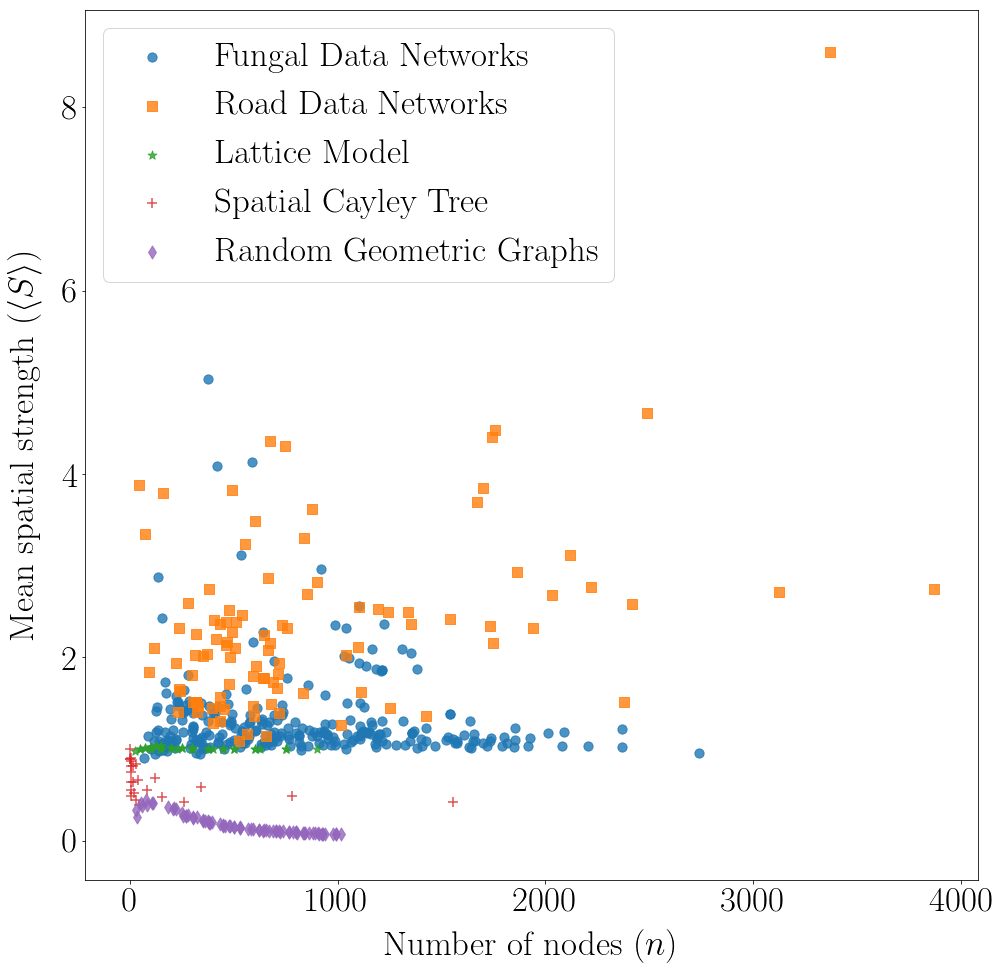

In [10]:
all_scatter = pickle.load(open('datasets/results/strengths_scatter_1', 'rb'))
fig = plt.figure(figsize=(16, 16))
labels = {
    'fungal': 'Fungal Data Networks',
    'roads': 'Road Data Networks',
    'lattice': 'Lattice Model',
    'web': 'Spatial Cayley Tree',
    'rgg2': 'Random Geometric Graphs',
    #'PA': 'Spatial Preferential Attachment'
}
for i, label in enumerate(labels):
    plt.scatter(all_scatter[label]['ns'], all_scatter[label]['strengths'], label=labels[label], marker=marker_cycle[i], s=85, alpha=0.8)

plt.xlabel('Number of nodes ($n$)', labelpad=10)
plt.ylabel('Mean spatial strength ({})'.format(r'$\langle S \rangle$'), labelpad=20)
plt.legend()
plt.savefig('figures/spatial_scatter_1.pdf', bbox_inches='tight')

In [ ]:
all_scatter_2 = {
    'fitness': {
        'ns': [],
        'strengths': []
    },
    'BA': {
        'ns': [],
        'strengths': []
    },
    'configuration': {
        
    }
}

In [33]:
fungal_set = pickle.load(open('datasets/results/fungal.pickle', 'rb'))
roads_set = pickle.load(open('datasets/results/roads.pickle', 'rb'))

In [98]:
all_scatter['rgg']

{'ns': [52,
  70,
  73,
  47,
  35,
  57,
  67,
  59,
  37,
  29,
  35,
  25,
  33,
  29,
  26,
  32,
  48,
  27,
  66,
  37,
  113,
  95,
  77,
  101,
  120,
  80,
  93,
  82,
  104,
  93,
  105,
  124,
  105,
  114,
  107,
  82,
  89,
  108,
  101,
  108,
  214,
  206,
  192,
  201,
  216,
  182,
  211,
  204,
  203,
  192,
  207,
  179,
  189,
  220,
  206,
  221,
  212,
  192,
  214,
  180,
  258,
  266,
  274,
  246,
  251,
  272,
  259,
  268,
  268,
  225,
  270,
  238,
  247,
  235,
  225,
  252,
  253,
  246,
  239,
  267,
  324,
  293,
  309,
  301,
  293,
  305,
  295,
  300,
  281,
  305,
  304,
  311,
  280,
  290,
  305,
  280,
  303,
  290,
  279,
  287,
  352,
  374,
  340,
  358,
  344,
  374,
  333,
  346,
  370,
  354,
  350,
  367,
  361,
  349,
  351,
  363,
  327,
  366,
  327,
  344,
  395,
  407,
  401,
  376,
  388,
  383,
  386,
  409,
  407,
  419,
  388,
  395,
  389,
  417,
  402,
  383,
  385,
  409,
  410,
  398,
  432,
  455,
  450,
  444,
  469,
  446,


In [80]:
r2 = r[r['spatial_strength'] <= 4]
r2 = r2[r2['type'] != 'lattice']
r2['type'] = r2['type'].map({
    'geographical': 'Fitness',
    'preferential': 'BA',
    'configuration': 'Configuration',
    'rgg': 'RGG',
    'web': 'Cayley',
    'fungal': 'Fungal',
    'roads': 'City'
})
r2['Spatial Strength'] = r2['spatial_strength']

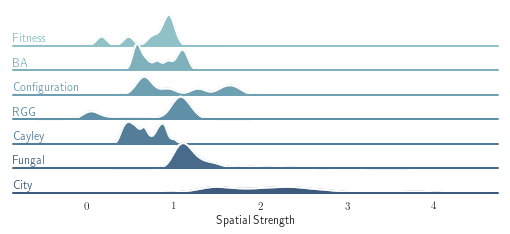

In [81]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(r2, row="type", hue="type", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Spatial Strength", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Spatial Strength", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    labels = {
        'geographical': '(a)',
        'preferential': '(b)',
        'configuration': '(c)',
        'rgg': '(d)',
        'lattice': '(e)',
        'web': '(f)',
        'fungal': '(g)',
        'roads': '(h)'
    }
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Spatial Strength")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.savefig('figures/spatial_strength_distributions.pdf', bbox_inches='tight')

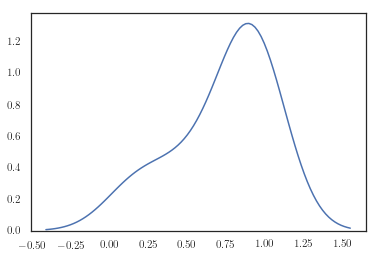

In [62]:
sns.kdeplot(list(r[r['type'] == 'geographical']['spatial_strength']))

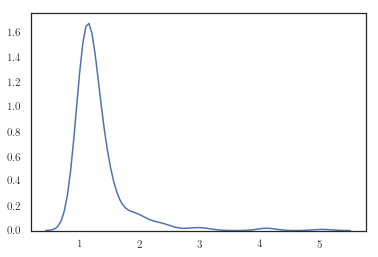

In [63]:
sns.kdeplot(list(r[r['type'] == 'fungal']['spatial_strength']))

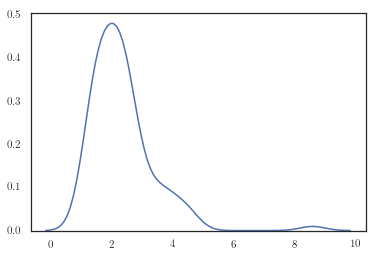

In [64]:
sns.kdeplot(list(r[r['type'] == 'roads']['spatial_strength']))

In [51]:
spatial_strength_data

{'configuration': {'-0.5': [0.65155281021006883,
   0.62839167108443172,
   0.66635237222456045,
   0.66484434060568587,
   0.61854507987209251,
   0.64919376775500537,
   0.65577856554819003,
   0.62957538786162726,
   0.63452031671052711,
   0.61636859763057361,
   0.64441922569584786,
   0.63327985008530419,
   0.63045224811002054,
   0.63749882373329658,
   0.65792328782805931,
   0.65052592709633528,
   0.65423579926515274,
   0.648771604122519,
   0.66367605978441713,
   0.74075042835445304,
   0.64585561266237901,
   0.63502892222412488,
   0.6254781859177061,
   0.62720802153296029,
   0.61769605853056975,
   0.66658078807914156,
   0.65052303051256544,
   0.6257689916536362,
   0.63912319295977182,
   0.68125781514625405],
  '-1.0': [0.65196558702410135,
   0.66255618318753462,
   0.67581156931546449,
   0.69707484915545637,
   0.69745584142823036,
   0.70349998415124126,
   0.71514747976768556,
   0.69483533510109363,
   0.68906941745490125,
   0.67484024745211235,
   0.71348

In [50]:
geo

{'-0.5': [<base_network_extensions.SimpleSpatialGraph at 0x172ff8d0>,
 '-1.0': [<base_network_extensions.SimpleSpatialGraph at 0x19d65590>,
 '-1.5': [<base_network_extensions.SimpleSpatialGraph at 0x1c817a10>,
 '-2.0': [<base_network_extensions.SimpleSpatialGraph at 0x20a25f10>,
 '-2.5': [<base_network_extensions.SimpleSpatialGraph at 0x23493e50>,
 '-3.0': [<base_network_extensions.SimpleSpatialGraph at 0x25f456d0>,
 '0.0': [<base_network_extensions.SimpleSpatialGraph at 0x134df730>,
  <base_network_extensions.SimpleSpatialGraph at 0x171b8570>]}

In [46]:
r2 = r.loc[0:50]

In [47]:
r2

,type,n,beta,spatial_strength
0,geographical,500,0.0,0.165026
1,geographical,500,-0.5,0.476170
2,geographical,500,-1.0,0.750201
3,geographical,500,-1.5,0.875527
4,geographical,500,-2.0,0.932179
5,geographical,500,-2.5,0.957817
6,geographical,500,-3.0,0.974800
7,preferential,500,0.0,0.558083
8,preferential,500,-0.5,0.564849
9,preferential,500,-1.0,0.595938


In [17]:
spatial_strength_results

{}

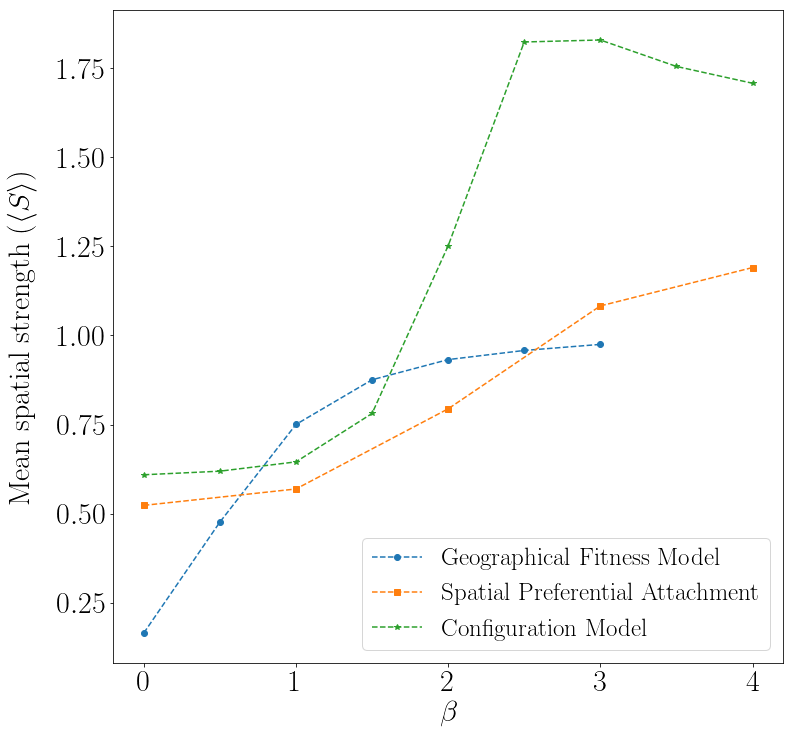

In [29]:
fig = plt.figure(figsize=(12, 12))
labels = {
    'geographical': 'Geographical Fitness Model',
    'preferential': 'Spatial Preferential Attachment',
    'configuration': 'Configuration Model'
}

reverse = False
#DOUBLE CHECK IF BETAS NEED TO BE REVERSED
#reverse betas

if(reverse):
    for graph_type in spatial_graph_keys:
        for i in range(len(spatial_strength_results[graph_type]['x'])):
            spatial_strength_results[graph_type]['x'][i] = -float(spatial_strength_results[graph_type]['x'][i])
    
for i, graph_type in enumerate(spatial_graph_keys):
    plt.plot(spatial_strength_results[graph_type]['x'], spatial_strength_results[graph_type]['y'], str(marker_cycle[i]) + '--', label=labels[graph_type])
plt.legend(fontsize=25)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Mean spatial strength ($\langle S \rangle$)', labelpad=20)
plt.savefig('figures\spatial_model_spatial_strengths2.pdf', bbox_inches='tight')

In [4]:
fig = plt.figure(figsize=(12, 12))
labels = {
    'geographical': 'Fitness',
    'preferential': 'Preferential Attachment',
    'configuration': 'Configuration'
}

#reverse betas
# for graph_type in spatial_graph_keys:
#     for i in range(len(spatial_strength_results[graph_type]['x'])):
#         spatial_strength_results[graph_type]['x'][i] = -float(spatial_strength_results[graph_type]['x'][i])
    
for i, graph_type in enumerate(spatial_graph_keys):
    plt.plot(spatial_strength_results[graph_type]['x'], spatial_strength_results[graph_type]['y'], str(marker_cycle[i]) + '--', label=labels[graph_type], markersize=10)
plt.legend(fontsize=25)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Mean spatial strength ($\langle S \rangle$)')
plt.savefig('figures\spatial_model_spatial_strengths2.pdf', bbox_inches='tight')

NameError: name 'spatial_graph_keys' is not defined

In [20]:
spatial_strength_results['geographical']['x']

['0.0', '-0.5', '-1.0', '-1.5', '-2.0', '-2.5', '-3.0']

In [32]:
def graph_spatial_network_plot_valued(G, values=False, graph_edges=False, hide_ticks=True, subplot=False,
    highlight_edges=False, highlight_recent=False, color_points=False, color_bar=False, bounds=False, pbc=True,
    edge_style=None, ss_title=False, alpha=0.2, linewidth=2):
    '''
    Create a plot showing what a 2D spatial graph looks like, coloring by passed values and sized by degree
    params:
        G: passed in SimpleSpatialGraph
        values: values according to the labels of the nodes
        graph_edges: graph edges as well (this function takes into account periodic boundary conditions)
        highlight_edges: Optionally parameter to draw in specific edges highlighted, will 
                also highlight the latest node
        color_points: array of color labels if coloring points specifically
        bounds: given by list of lists - each row with two entries
        pbc: whether to graph as pbc
    '''
    X = []
    Y = []
    degrees = []
    scatter_values = []

    if(subplot):
        plt.subplot(subplot[0], subplot[1], subplot[2])
    else:
        plt.figure(figsize=(16, 16))
    for i in list(G.nodes):
        coordinate = G.nodes[i]['coordinate']
        X.append(coordinate[0])
        Y.append(coordinate[1])
        degrees.append(G.degree[i])
        if(values):
            scatter_values.append(values[i])
    
    if(ss_title):
        _, spatial_strength = report_spatial_strength_centrality(G, pbc=pbc, graph=False,
            ret=True, normalized=4)
        plt.title(r'$\langle S \rangle \approx {0:.3f}$'.format(spatial_strength), y=1.05)
    if(graph_edges):
        if(pbc):
                for i in G.edges:
                    coordinate_i = G.nodes[i[0]]['coordinate']
                    coordinate_j = G.nodes[i[1]]['coordinate']
                    points = False
                    if(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2 and
                            abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
                        max_x = max(coordinate_i[0], coordinate_j[0])
                        max_y = max(coordinate_i[1], coordinate_j[1])
                        min_x = min(coordinate_i[0], coordinate_j[0])
                        min_y = min(coordinate_i[1], coordinate_j[1])
                        x1 = (max_x, max_x + 50)
                        x2 = (min_x, min_x - 50)
                        y1 = (max_y, max_y + 50)
                        y2 = (min_y, min_y - 50)
                        points = (x1, x2, y1, y2)
                    elif(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2):
                        coordinates = sorted([[coordinate_i[0], coordinate_i[1]], 
                            [coordinate_j[0], coordinate_j[1]]])
                        x1 = (coordinates[1][0], coordinates[1][0] + 50)
                        x2 = (coordinates[0][0], coordinates[0][0] - 50)
                        y1 = (coordinates[1][1], coordinates[0][1])
                        y2 = (coordinates[0][1], coordinates[1][1])
                        points = (x1, x2, y1, y2)
                    elif(abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
                        coordinates = sorted([[coordinate_i[1], coordinate_i[0]], 
                            [coordinate_j[1], coordinate_j[0]]])
                        y1 = (coordinates[1][0], coordinates[1][0] + 50)
                        y2 = (coordinates[0][0], coordinates[0][0] - 50)
                        x1 = (coordinates[1][1], coordinates[0][1])
                        x2 = (coordinates[0][1], coordinates[1][1])
                        points = (x1, x2, y1, y2)

                    if(points):
                        plt.plot(points[0], points[2], alpha=alpha, color='grey')
                        plt.plot(points[1], points[3], alpha=alpha, color='grey')
                    else:
                        x = (coordinate_i[0], coordinate_j[0])
                        y = (coordinate_i[1], coordinate_j[1])
                        plt.plot(x, y, alpha=alpha, color='grey', linewidth=linewidth)
        else:
                for i in G.edges:
                    coordinate_i = G.nodes[i[0]]['coordinate']
                    coordinate_j = G.nodes[i[1]]['coordinate']
                    x = (coordinate_i[0], coordinate_j[0])
                    y = (coordinate_i[1], coordinate_j[1])
                    plt.plot(x, y, alpha=alpha, color='grey', linewidth=linewidth)

    if(highlight_edges):
        for i in highlight_edges:
            coordinate_i = G.nodes[i[0]]['coordinate']
            coordinate_j = G.nodes[i[1]]['coordinate']
            x = (coordinate_i[0], coordinate_j[0])
            y = (coordinate_i[1], coordinate_j[1])
            plt.plot(x, y, alpha=alpha, color='red')

    if(color_points):
        plt.scatter(X, Y, c=color_points, s=degrees)
    elif(color_bar):
        plt.scatter(X, Y, c=scatter_values, s=degrees, cmap='viridis')
        plt.colorbar()
    else:
        plt.scatter(X, Y, c='grey', s=degrees)
        
    if(highlight_recent):
        node = G.nodes[len(G.nodes) - 1]
        x = [node['coordinate'][0]]
        y = [node['coordinate'][1]]
        plt.scatter(x, y, c='red')
    if(bounds):
        plt.xlim([bounds[0][0], bounds[0][1]])
        plt.ylim([bounds[1][0], bounds[1][1]])
    else:
        plt.xlim([0, G.size[0]])
        plt.ylim([0, G.size[1]])

    if(hide_ticks):
        plt.xticks([])
        plt.yticks([])

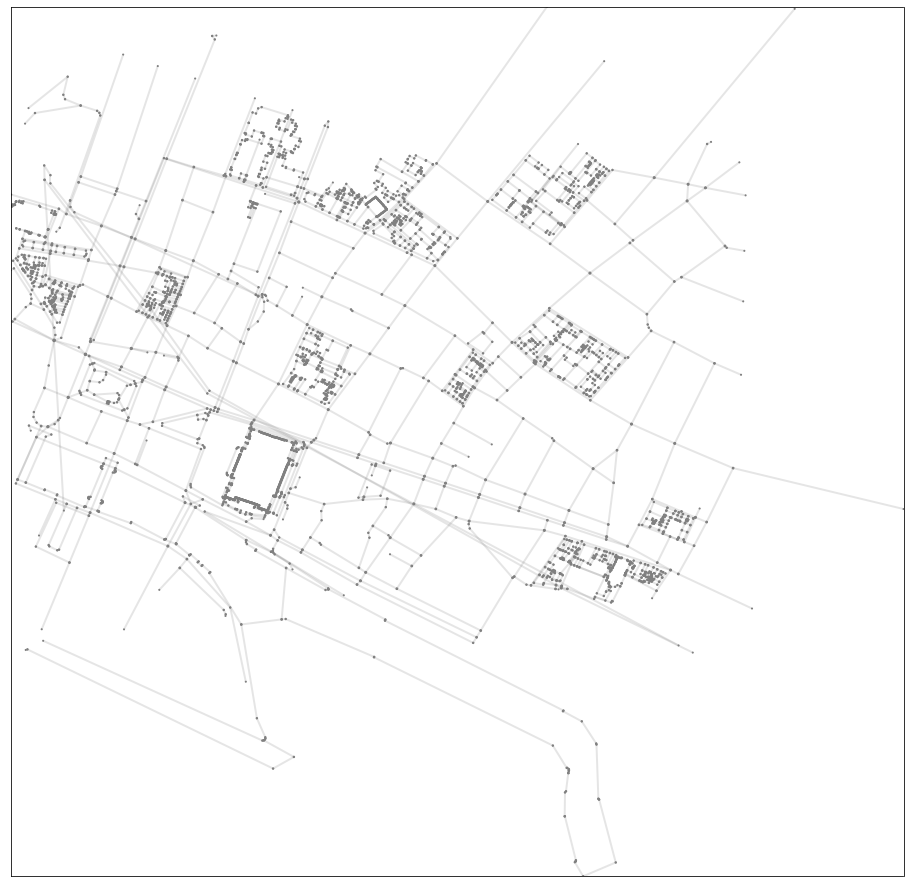

In [33]:
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False)
plt.savefig('paris_network.pdf', bbox_inches='tight')

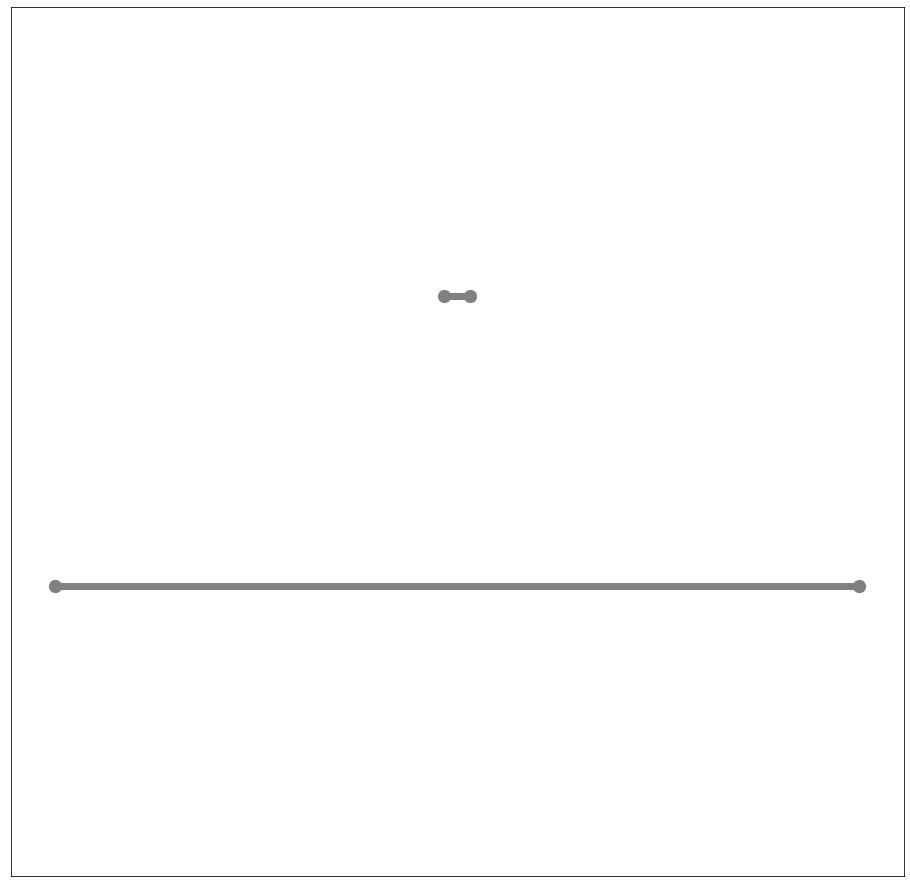

In [29]:
g = SimpleSpatialGraph(size=[100, 6])
g.add_node(coordinate=[5,2])
g.add_node(coordinate=[95, 2])
g.add_node(coordinate=[48.5, 4])
g.add_node(coordinate=[51.5, 4])
g.add_edge(0, 1)
g.add_edge(2, 3)
matplotlib.rc('font', size=55)
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False, alpha=1, ss_title=False, linewidth=7, subplot=False)
#report_spatial_strength_centrality(g, pbc=False, graph=False, ret=False, normalized=4)
plt.savefig('figures/breaking_example_spatial_strength.pdf', bbox_inches='tight')

Average Spatial Strength: 0.300350338168
Average Spatial Strength: 0.430409107099


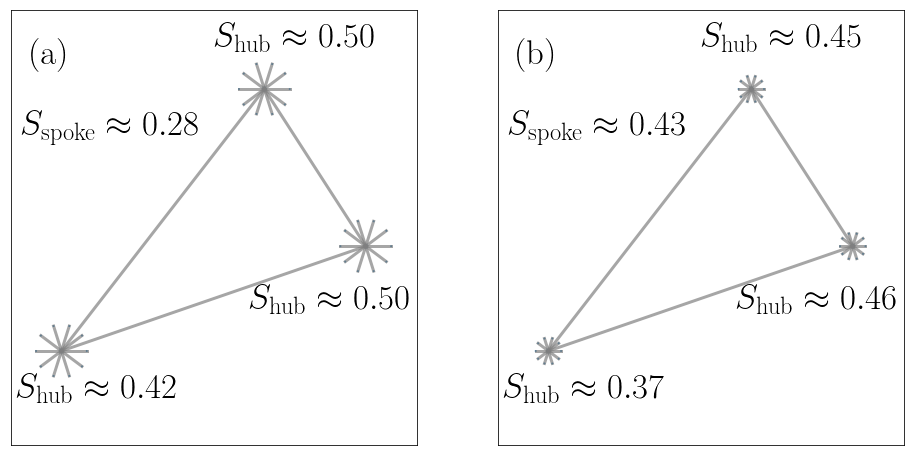

In [29]:
#create a representative hub/leaf network
plt.figure(figsize=(16, 8))

g = SimpleSpatialGraph(size=[8, 8])
hubs = [[1, 2], [5, 7], [7, 4]]
hub_labels = []
for coord in hubs:
    hub = g.node_count
    hub_labels.append(hub)
    g.add_node(coordinate=coord)
    for i in range(10):
        coord2 = [coord[0] + 0.5 * math.cos(2 * math.pi * (i / 10)), coord[1] + 0.5 * math.sin(2 * math.pi * (i / 10))]
        g.add_node(coordinate=coord2)
        g.add_edge(g.node_count - 1, hub)
for i in range(3):
    for j in range(i, 3):
        g.add_edge(hub_labels[i], hub_labels[j])
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False, hide_ticks=True, alpha=0.7, linewidth=3, ss_title=False,
                                 subplot=[1, 2, 1])
centralities, spatial_strength = report_spatial_strength_centrality(g, pbc=False, graph=False, ret=True)
for i, coord in enumerate(hubs):
    if(i == 1):
        plt.text(coord[0] - 1, coord[1] + 0.7, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
    elif(i == 0):
        plt.text(coord[0] - 0.9, coord[1] - 1, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
    else:
        plt.text(coord[0] - 2.3, coord[1] - 1.3, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
plt.ylim([0.2, 8.5])
plt.text(0.2, 6, r'$S_{\mathrm{spoke}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][1]))
ax = plt.gca()
plt.text(0.1, 0.9, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

hub = g

g = SimpleSpatialGraph(size=[8, 8])
hubs = [[1, 2], [5, 7], [7, 4]]
hub_labels = []
for coord in hubs:
    hub = g.node_count
    hub_labels.append(hub)
    g.add_node(coordinate=coord)
    for i in range(10):
        coord2 = [coord[0] + 0.25 * math.cos(2 * math.pi * (i / 10)), coord[1] + 0.25 * math.sin(2 * math.pi * (i / 10))]
        g.add_node(coordinate=coord2)
        g.add_edge(g.node_count - 1, hub)
for i in range(3):
    for j in range(i, 3):
        g.add_edge(hub_labels[i], hub_labels[j])
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False, hide_ticks=True, alpha=0.7, linewidth=3, ss_title=False,
                                 subplot=[1, 2, 2])
centralities, spatial_strength = report_spatial_strength_centrality(g, pbc=False, graph=False, ret=True)
for i, coord in enumerate(hubs):
    if(i == 1):
        plt.text(coord[0] - 1, coord[1] + 0.7, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
    elif(i == 0):
        plt.text(coord[0] - 0.9, coord[1] - 1, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
    else:
        plt.text(coord[0] - 2.3, coord[1] - 1.3, r'$S_{\mathrm{hub}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][i * 11]))
plt.ylim([0.2, 8.5])
plt.text(0.2, 6, r'$S_{\mathrm{spoke}}' + r' \approx {0:.2f}$'.format(centralities['spatial_strength'][1]))
ax = plt.gca()
plt.text(0.1, 0.9, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

hub = g
plt.savefig('figures/hub_spoke_detailed2.pdf', bbox_inches='tight')

In [11]:
centralities['spatial_strength']

{0: 0.42131359622786302,
 1: 0.2830783135695864,
 2: 0.2830783135695864,
 3: 0.2830783135695864,
 4: 0.2830783135695864,
 5: 0.2830783135695864,
 6: 0.2830783135695864,
 7: 0.2830783135695864,
 8: 0.2830783135695864,
 9: 0.2830783135695864,
 10: 0.2830783135695864,
 11: 0.4976396765218295,
 12: 0.2830783135695864,
 13: 0.28307831356958657,
 14: 0.28307831356958646,
 15: 0.28307831356958646,
 16: 0.28307831356958657,
 17: 0.2830783135695864,
 18: 0.28307831356958607,
 19: 0.28307831356958635,
 20: 0.28307831356958646,
 21: 0.28307831356958657,
 22: 0.5002584796922882,
 23: 0.2830783135695864,
 24: 0.28307831356958657,
 25: 0.28307831356958646,
 26: 0.28307831356958646,
 27: 0.28307831356958657,
 28: 0.2830783135695864,
 29: 0.28307831356958607,
 30: 0.28307831356958635,
 31: 0.28307831356958646,
 32: 0.28307831356958657}

In [18]:
font = {'size' : 45,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

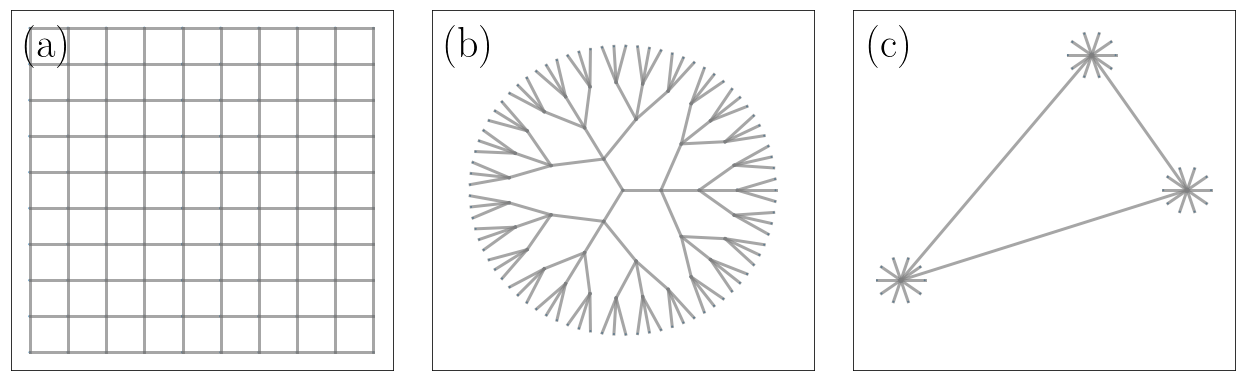

In [21]:
plt.figure(figsize=(18, 6))
matplotlib.rc('font', size=30)

web = generate_web()
lattice = generate_lattice(rows=10, columns=10)


graph_spatial_network_plot_valued(lattice, False, True, pbc=False, subplot=(1, 3, 1), ss_title=False, alpha=0.7, linewidth=3)
ax = plt.gca()
plt.text(0.1, 0.9, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=42)

graph_spatial_network_plot_valued(web, False, True, pbc=False, subplot=(1, 3, 2), ss_title=False, alpha=0.7, linewidth=3)
ax = plt.gca()
plt.text(0.1, 0.9, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=42)

graph_spatial_network_plot_valued(hub, False, True, pbc=False, subplot=(1, 3, 3), ss_title=False, alpha=0.7, linewidth=3)
ax = plt.gca()
plt.text(0.1, 0.9, '(c)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=42)

plt.tight_layout()
plt.savefig('figures/toy_network_examples.pdf', bbox_inches='tight')

In [30]:
city = get_city_by_index(20)
fungal = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[92], 'rb'))
rgg = pickle.load(open('spatial_rgg_example', 'rb'))

Africa
Tunis.pickle


In [31]:
'datasets/fungal_networks/' + listdir('datasets/fungal_networks')[92]

'datasets/fungal_networks/Pv_M_I+4R_U_N_21d_4.pickle'

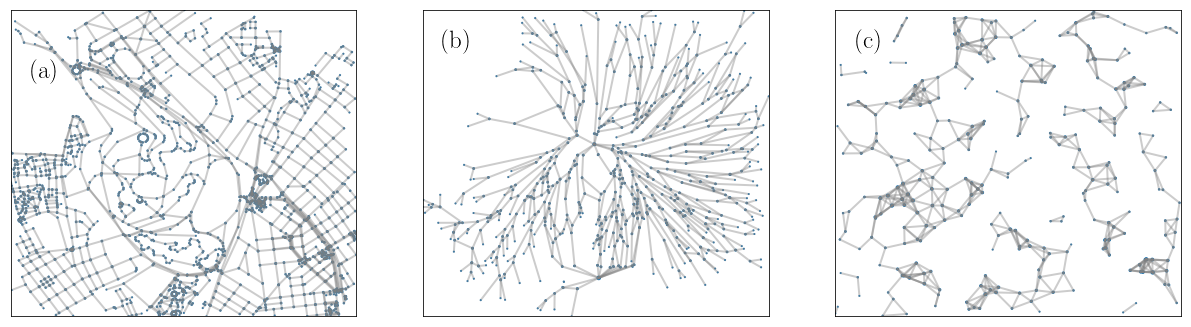

In [35]:
plt.figure(figsize=(18, 6))
graph_spatial_network_plot_valued(city, False, True, pbc=False, subplot=(1, 3, 1), ss_title=False, alpha=0.4)
ax = plt.gca()
plt.text(0.1, 0.8, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=25)

graph_spatial_network_plot_valued(fungal, False, True, pbc=False, subplot=(1, 3, 2), ss_title=False, alpha=0.4)
ax = plt.gca()
plt.text(0.1, 0.9, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=25)

graph_spatial_network_plot_valued(rgg, False, True, pbc=False, subplot=(1, 3, 3), ss_title=False, alpha=0.4)
ax = plt.gca()
plt.text(0.1, 0.9, '(c)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=25)

plt.tight_layout()
plt.savefig('figures/data_network_examples.pdf', bbox_inches='tight')

In [37]:
type(city)

NoneType

In [65]:
r.append({'beta': 5, 'n': 500, 'type': 'threshold'})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

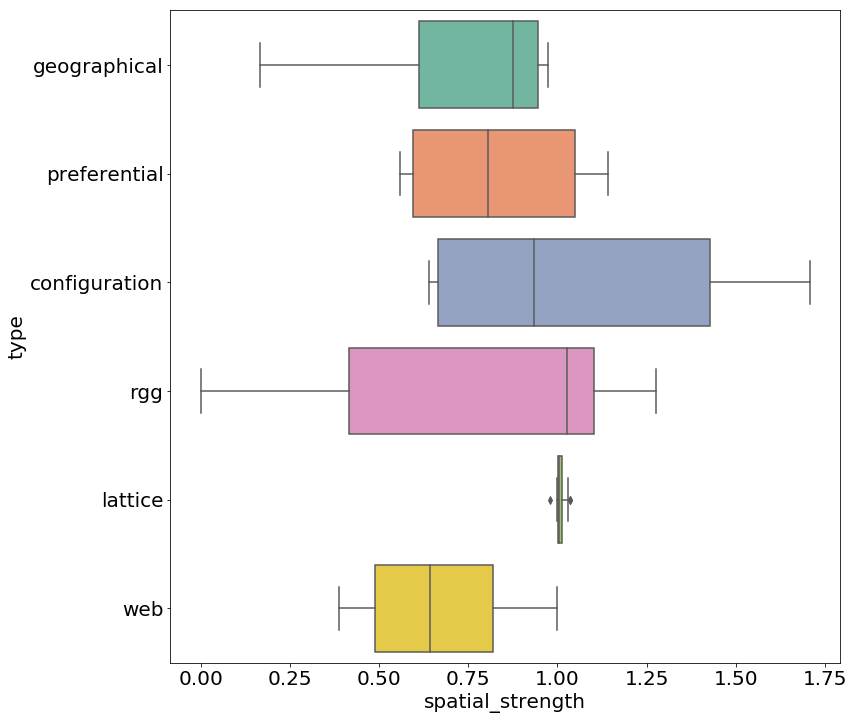

In [110]:
fig = plt.figure(figsize=(12, 12))
ax = sns.boxplot(orient='h', x='spatial_strength', y='type', data=r, palette='Set2')
#ax = sns.swarmplot(orient='h', x='spatial_strength', y='type', data=r, hue='n', dodge=False)


In [79]:


sio.loadmat('datasets/Conductance')

,beta,n,type
0,5,500,threshold
1,-3.0,500,geographical
2,-4.0,500,preferential
3,-3.0,500,configuration


In [ ]:
spatial_strengths = []
file_count = 0
files = len(listdir('datasets/Conductance'))
for file in listdir('datasets/Conductance'):
    print('file ' + str(file_count) + ' of ' + str(files))
    file_count += 1
    g = load_fungal_network(file)
    savename = file.split('.mat')[0]
    pickle.dump(g, open('datasets/fungal_networks/' + savename + '.pickle', 'wb'))
    _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
    spatial_strengths.append(spatial_strength)

In [37]:
len(g.nodes)

4

In [39]:
mean_degrees = []
ns = []
for file in listdir('datasets/fungal_networks'):
    print(file)
    g = pickle.load(open('datasets/fungal_networks/' + file, 'rb'))
    mean_degrees.append(average_degree(g))
    ns.append(len(g.nodes))

Ag_M_I+4R_U_N_42d_1.pickle
Pi_M_I_U_N_46d_1.pickle
Pi_M_I_U_N_46d_2.pickle
Pi_M_I_U_N_46d_3.pickle
Pi_M_I_U_N_46d_4.pickle
Pi_M_I_U_N_46d_5.pickle
Pi_M_I_U_N_46d_6.pickle
Pi_M_I_U_N_46d_7.pickle
Pp_M_Tokyo_U_N_26h_1.pickle
Pp_M_Tokyo_U_N_26h_11.pickle
Pp_M_Tokyo_U_N_26h_2.pickle
Pp_M_Tokyo_U_N_26h_4.pickle
Pp_M_Tokyo_U_N_26h_6.pickle
Pp_M_Tokyo_U_N_26h_7.pickle
Pp_M_Tokyo_U_N_26h_9.pickle
Pp_M_UK_U_N_15h_1.pickle
Pp_M_UK_U_N_15h_10.pickle
Pp_M_UK_U_N_15h_11.pickle
Pp_M_UK_U_N_15h_12.pickle
Pp_M_UK_U_N_15h_2.pickle
Pp_M_UK_U_N_15h_6.pickle
Pp_M_UK_U_N_15h_7.pickle
Pp_M_UK_U_N_15h_8.pickle
Pp_M_UK_U_N_15h_9.pickle
Pv_L_I+4xR_Fc_N_155d_1.pickle
Pv_L_I+4xR_Fc_N_155d_2.pickle
Pv_L_I+4xR_Fc_N_155d_3.pickle
Pv_L_I+4xR_Fc_N_208d_1.pickle
Pv_L_I+4xR_Fc_N_208d_2.pickle
Pv_L_I+4xR_Fc_N_208d_3.pickle
Pv_L_I+4xR_Fc_N_36d_1.pickle
Pv_L_I+4xR_Fc_N_36d_2.pickle
Pv_L_I+4xR_Fc_N_36d_3.pickle
Pv_L_I+4xR_Fc_N_57d_1.pickle
Pv_L_I+4xR_Fc_N_57d_2.pickle
Pv_L_I+4xR_Fc_N_57d_3.pickle
Pv_L_I+4xR_Fc_N_78d_1.pick

In [47]:
len(ns)

270

In [49]:
ns[92]

641

In [46]:
print(np.min(ns))
print(np.max(ns))


69
2741


In [44]:
mean_degrees2 = []
ns2 = []
for country in listdir('datasets/road_networks'):
    for file in listdir('datasets/road_networks/' + country):
        print(file)
        g = pickle.load(open('datasets/road_networks/' + country + '/' + file, 'rb'))
        mean_degrees2.append(average_degree(g))
        ns2.append(len(g.nodes))

Abidjan.pickle
Accra.pickle
AddisAbaba.pickle
Alexandria.pickle
Algiers.pickle
Cairo.pickle
CapeTown.pickle
Casablanca.pickle
Dakar.pickle
DarEsSalaam.pickle
Durban.pickle
Ibadan.pickle
Johannesburg.pickle
Kano.pickle
Khartoum.pickle
Kinshasa.pickle
Lagos.pickle
Luanda.pickle
Nairobi.pickle
Pretoria.pickle
Tunis.pickle
Bangkok.pickle
Beijing.pickle
Delhi.pickle
Dhaka.pickle
Guangzhou.pickle
HongKong.pickle
Jakarta.pickle
Karachi.pickle
Kolkata.pickle
Manila.pickle
Mumbai.pickle
Nagoya.pickle
Osaka.pickle
Seoul.pickle
Shanghai.pickle
Shenzhen.pickle
Taipei.pickle
Tehran.pickle
Tokyo.pickle
Wuhan.pickle
Barcelona.pickle
Berlin.pickle
Brussels.pickle
Bucharest.pickle
Budapest.pickle
Hamburg.pickle
London.pickle
Lyon.pickle
Madrid.pickle
Marseille.pickle
Milan.pickle
Munich.pickle
Naples.pickle
Paris.pickle
Prague.pickle
Rome.pickle
Sofia.pickle
Valencia.pickle
Vienna.pickle
Warsaw.pickle
BeloHorizonte.pickle
Bogota.pickle
Brasilia.pickle
BuenosAires.pickle
Caracas.pickle
Fortaleza.pickle


In [36]:
mean_degrees2 = []
ns2 = []
for country in listdir('datasets/road_networks'):
    print(country)
    country_count = 0
    for file in listdir('datasets/road_networks/' + country):
        country_count += 1
    print(country_count)


Africa_2km
21
Asia_2km
20
Europe_2km
20
LatinAmerica_2km
20
US_2km
20


In [48]:
print(np.mean(ns2))
print(np.min(ns2))
print(np.max(ns2))
print(len(ns2))

874.227722772
43
3870
101


In [254]:
spatial_strengths = []
for file in listdir('datasets/fungal_networks'):
    g = pickle.load(open('datasets/fungal_networks/' + file, 'rb'))
    _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
    spatial_strengths.append(spatial_strength)

pickle.dump(spatial_strengths, open('datasets/results/fungal.pickle', 'wb'))

In [50]:
fungal = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[92], 'rb'))
g2 = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[225], 'rb'))


In [51]:
len(g2.nodes)

69

In [45]:
listdir('datasets/fungal_networks')[92]

'Pv_M_I+4R_U_N_21d_4.pickle'

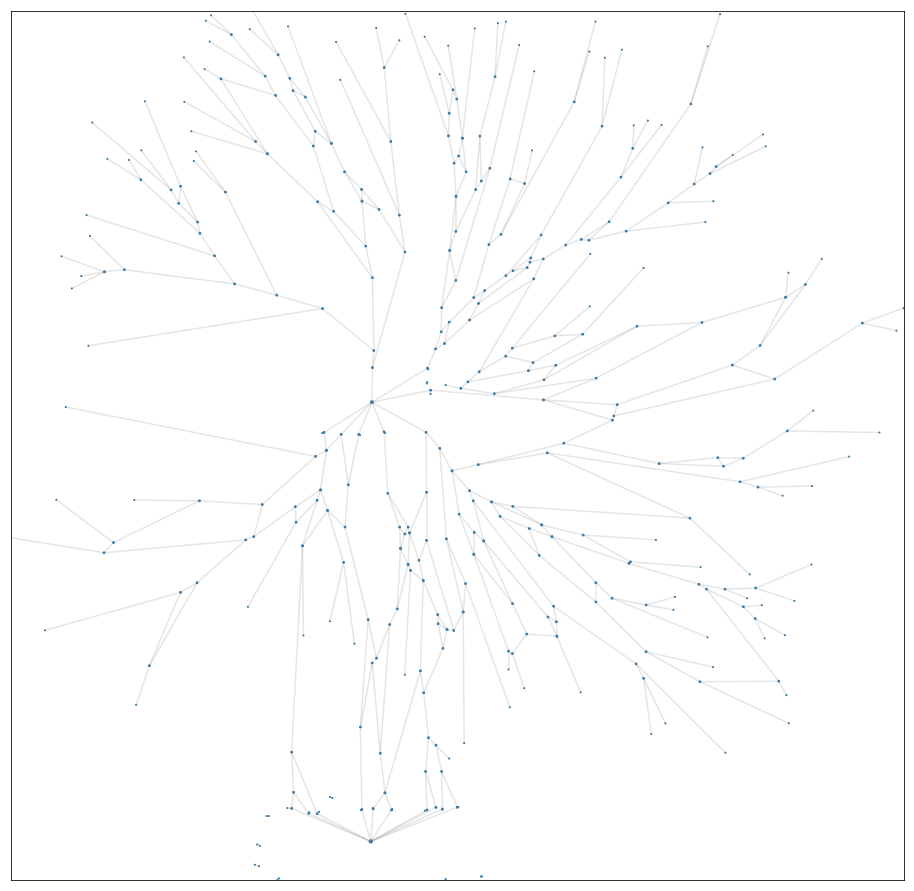

In [20]:
graph_spatial_network_plot_valued(g1, graph_edges=True, pbc=False)

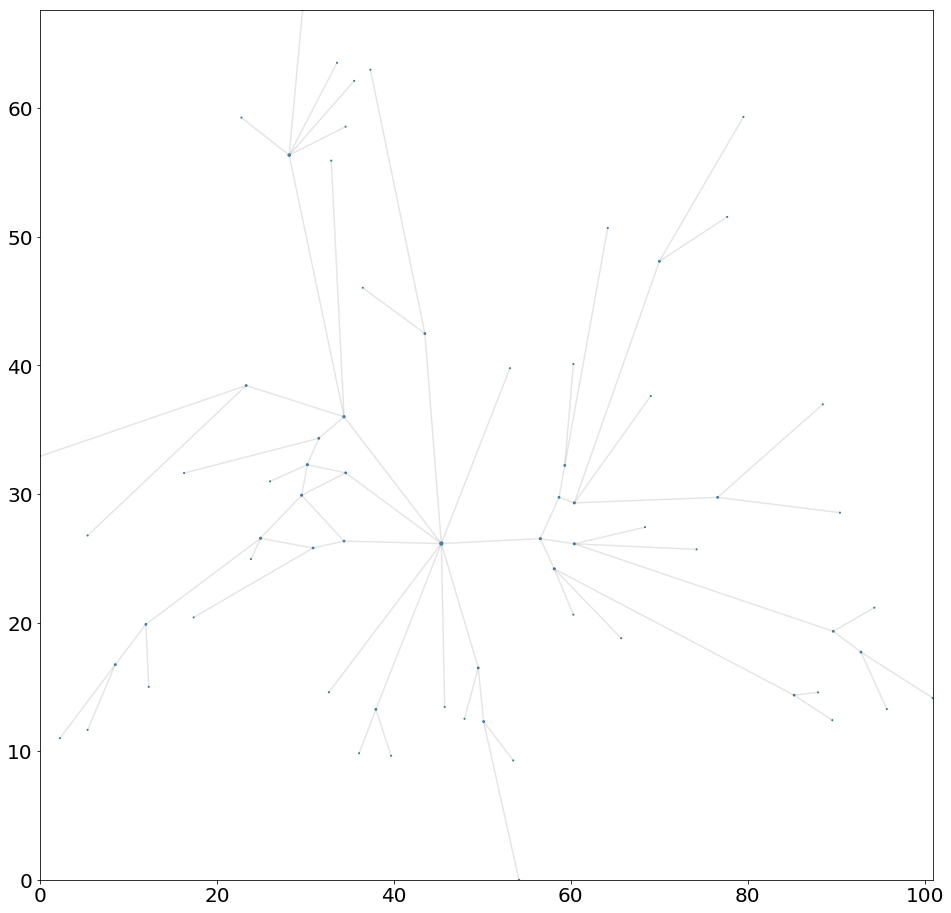

In [188]:
graph_spatial_network_plot_valued(g2, graph_edges=True, pbc=False)

In [9]:
spatial_strengths = {}
countries = []
for country in listdir('datasets/road_networks'):
    countries.append(country.split('_2km')[0])
    
    
spatial_strengths = {}


for i, country in enumerate(listdir('datasets/road_data_2km')):
    print('country: ' + country)
    city_count = 0
    cities = []
    spatial_strengths[countries[i]] = []
    
    for file in listdir('datasets/road_data_2km/' + country):
        if('.pdf') in file:
            city = file.split('.pdf')[0]
            cities.append(city)
        
    for city in cities:
        print(str(city_count) + ' of ' + str(len(cities)))
        city_count += 1
        g = load_city_network(country, city)
        pickle.dump(g, open('datasets/road_networks/' + country + '/' + city.split('_network')[0] + '.pickle', 'wb'))
        _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
        spatial_strengths[countries[i]].append(spatial_strength)
        
for country in countries:
    print(np.array(spatial_strengths[country]).max())
    

country: Africa_2km
0 of 21
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
country: Asia_2km
0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20
country: Europe_2km
0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20
country: LatinAmerica_2km
0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20
country: US_2km
0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20


In [14]:
d = np.array(spatial_strengths['Europe'])

In [18]:
city_count = 0
cities = []
for file in listdir('datasets/road_data_2km/' + 'Europe_2km'):
    if('.pdf') in file:
        city = file.split('.pdf')[0]
        cities.append(city)
        

In [16]:
d.argmax()

13

In [23]:
g = pickle.load(open('datasets/road_networks/Europe_2km/Paris.pickle', 'rb'))

In [26]:
_, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=True)

Average Spatial Strength: 8.602324039984532


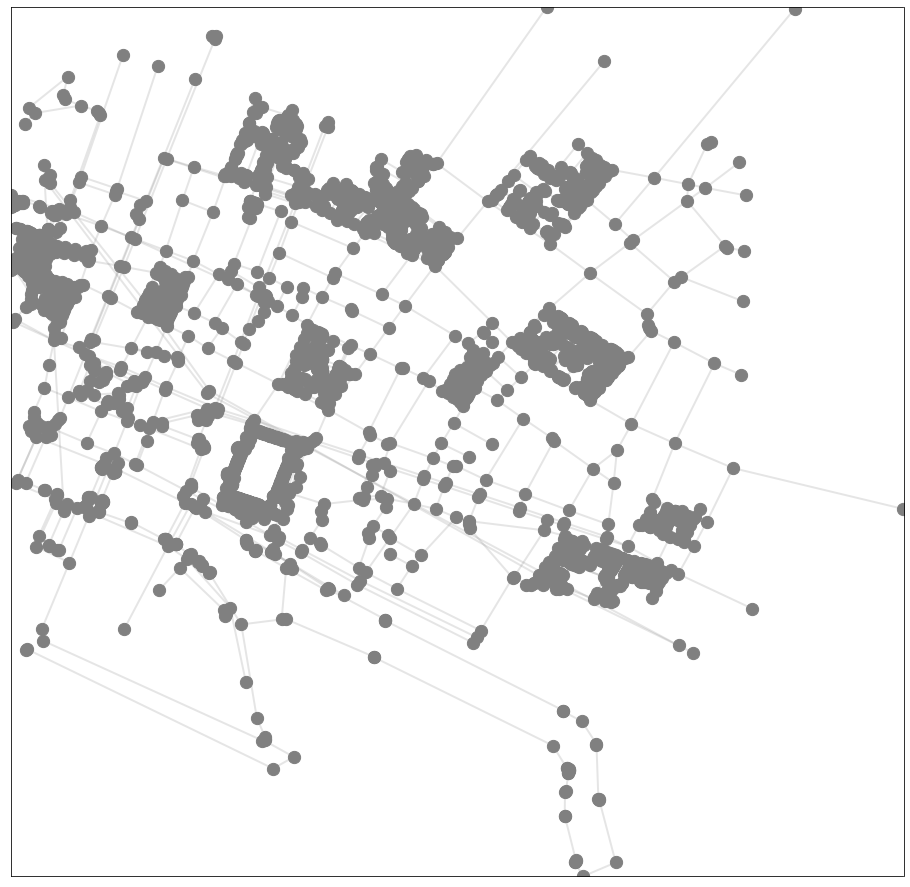

In [22]:

for country in listdir('datasets/road_data_2km'):
    print('country: ' + country)
    city_count = 0
    cities = []
    for file in listdir('datasets/road_data_2km/' + country):
        if('.pdf') in file:
            city = file.split('.pdf')[0]
            cities.append(city)
        
    for city in cities:
        print(str(city_count) + ' of ' + str(len(cities)))
        city_count += 1
        g = load_city_network(country, city)
        pickle.dump(g, open('datasets/road_networks/' + country + '/' + city.split('_network')[0] + '.pickle', 'wb'))
        _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
        spatial_strengths.append(spatial_strength)

country: Africa_2km
0 of 21
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21


KeyboardInterrupt: 

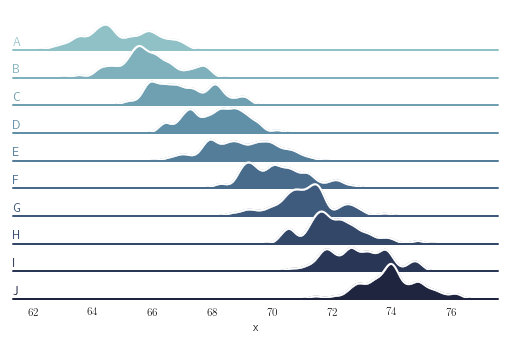

In [7]:
df

,g,x
0,A,64.038123
1,B,66.147050
2,C,66.370011
3,D,68.791019
4,E,70.583534
5,F,69.135114
6,G,72.390092
7,H,73.822191
8,I,73.868785
9,J,72.938377


In [236]:
road_spatial_strengths = {
    'all_results': spatial_strengths
}
city_count = 0
for country in listdir('datasets/road_networks'):
    city_spatial_strengths = []
    
    for i in range(len(listdir('datasets/road_networks/' + country))):
        city_spatial_strengths.append(spatial_strengths[i])
        city_count += 1
        
    road_spatial_strengths[country.split('_2km')[0]] = city_spatial_strengths

#pickle.dump(road_spatial_strengths, open('datasets/results/roads.pickle', 'wb'))

In [32]:
road_spatial_strengths = pickle.load(open('datasets/results/roads.pickle', 'rb'))

In [34]:
max_country = None
max_index = 0
max_s = 0
for country in listdir('datasets/road_networks'):
    for i in range(len(listdir('datasets/road_networks/' + country))):
        if(road_spatial_strengths[country.split('_2km')[0]][i] > max_s):
            max_s = road_spatial_strengths[country.split('_2km')[0]][i]
            max_country = country.split('_2km')
            max_index = i

In [39]:
countries

['Africa', 'Asia', 'Europe', 'LatinAmerica', 'US']

In [40]:
road_spatial_strengths

{'Africa': [1.94003680758154,
  2.2567618642970557,
  1.4748049683462365,
  1.652407317817002,
  1.7980999591880582,
  1.9407768138814532,
  2.0269538530237368,
  1.776906640743332,
  2.0791191539848475,
  2.2051834477147305,
  1.7150522613986892,
  1.2819679150707384,
  1.3017379096721409,
  3.8816761460241795,
  1.0857544267979906,
  2.0375824340058895,
  1.5090038931091065,
  2.170693932937994,
  4.305383446413998,
  2.3234516389502904,
  2.3389700387501176],
 'Asia': [1.94003680758154,
  2.2567618642970557,
  1.4748049683462365,
  1.652407317817002,
  1.7980999591880582,
  1.9407768138814532,
  2.0269538530237368,
  1.776906640743332,
  2.0791191539848475,
  2.2051834477147305,
  1.7150522613986892,
  1.2819679150707384,
  1.3017379096721409,
  3.8816761460241795,
  1.0857544267979906,
  2.0375824340058895,
  1.5090038931091065,
  2.170693932937994,
  4.305383446413998,
  2.3234516389502904],
 'Europe': [1.94003680758154,
  2.2567618642970557,
  1.4748049683462365,
  1.652407317817

In [52]:
city = get_city_by_index(20)

Africa
Tunis.pickle


In [55]:
len(city.nodes)

1731

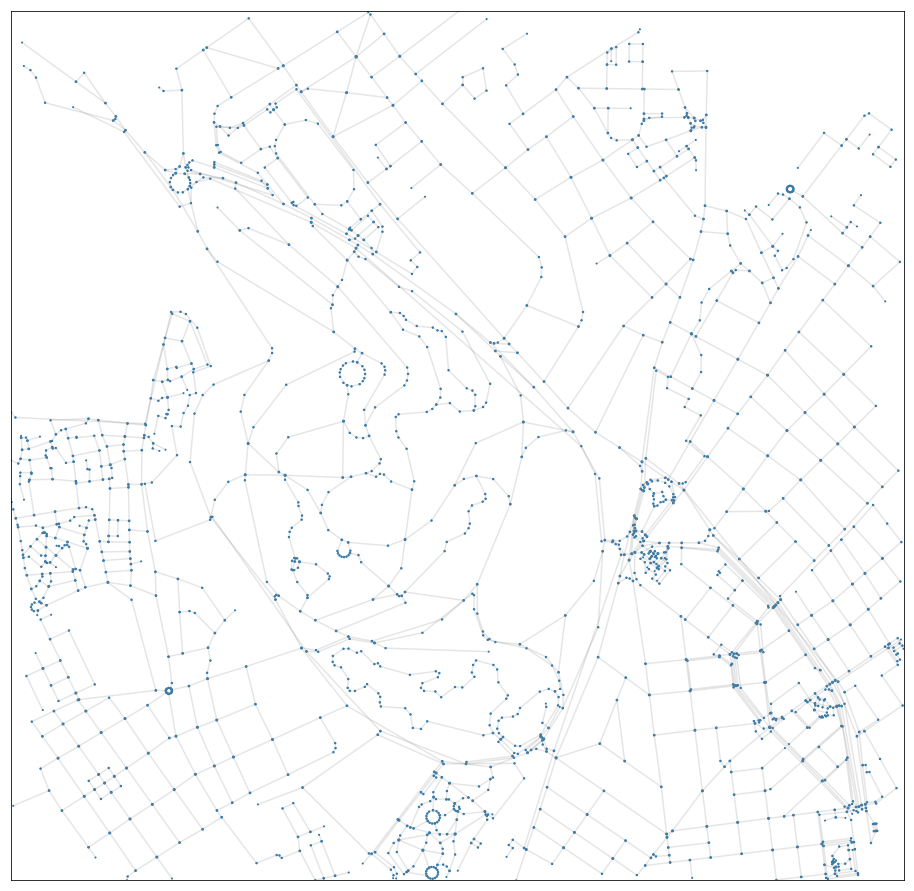

In [23]:
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False)